In [ ]:
%%capture
!mkdir Data
!wget --directory-prefix=./Data https://raw.githubusercontent.com/pymc-devs/pymc-resources/main/Rethinking_2/Data/islandsDistMatrix.csv
!wget --directory-prefix=./Data https://raw.githubusercontent.com/pymc-devs/pymc-resources/main/Rethinking_2/Data/Kline2.csv 

## Questions
 Use WAIC to compare the Gaussian process model of Oceanic tools to the models fit to the same data in Chapter 11. Pay special attention to the effective numbers of parameters, as estimated by WAIC.
 
The model that conforms to the research hypothesis includes an interaction between log population and contact rate:



### import

In [ ]:
import warnings


import aesara.tensor as at
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import scipy as sp

from scipy import stats
from scipy.special import expit as logistic
from scipy.special import softmax


from matplotlib.patches import Ellipse, transforms
from scipy import stats


In [ ]:
%config InlineBackend.figure_format = 'retina'
warnings.simplefilter(action="ignore", category=(FutureWarning, UserWarning))
RANDOM_SEED = 8927
np.random.seed(RANDOM_SEED)
az.style.use("arviz-darkgrid")
az.rcParams["stats.hdi_prob"] = 0.89
az.rcParams["stats.ic_scale"] = "deviance"
az.rcParams["stats.information_criterion"] = "waic"


def standardize(series):
    """Standardize a pandas series"""
    return (series - series.mean()) / series.std()

### Data

The book doesn't pre-process the population data, but if you give them raw to PyMC, the sampler will break: the scale of these data is too wide. However we can't just standardize the data, as we usually do. Why? Because some data points will then be negative, which doesn't play nice with the `b` exponent (try it if you don't trust me). But we'll do something similar: let's standardize the data, and then just add the absolute value of the minimum, and add yet again an epsilon -- this will ensure that our data stay positive and that the transformation will be easy to reverse when we want to plot on the natural scale:

In [ ]:
dk = pd.read_csv("Data/Kline2.csv", sep=",") #basic data of islands
Dmat = pd.read_csv("Data/islandsDistMatrix.csv", sep=",",index_col=0)#distance data of each island
Dmat.round(1)
Nsociety = dk.shape[0] #get id number of islands
society = np.arange(Nsociety) # name id number array society
total_tools = dk.total_tools.values #store total_tools values

Dmat = Dmat.values #distance valuse
Dmatsq = np.power(Dmat, 2) #squared of distance valuse

P = standardize(np.log(dk.population)).values
P = P + np.abs(P.min()) + 0.1 #ensure data stay positive

c_id = (dk.contact == "high").astype(int).values #change value of contact "high" to "1", "low" to "0" 


In [ ]:
dk #show the basic data

culture  population contact  total_tools  mean_TU   lat    lon  lon2  \
0    Malekula        1100     low           13      3.2 -16.3  167.5 -12.5   
1     Tikopia        1500     low           22      4.7 -12.3  168.8 -11.2   
2  Santa Cruz        3600     low           24      4.0 -10.7  166.0 -14.0   
3         Yap        4791    high           43      5.0   9.5  138.1 -41.9   
4    Lau Fiji        7400    high           33      5.0 -17.7  178.1  -1.9   
5   Trobriand        8000    high           19      4.0  -8.7  150.9 -29.1   
6       Chuuk        9200    high           40      3.8   7.4  151.6 -28.4   
7       Manus       13000     low           28      6.6  -2.1  146.9 -33.1   
8       Tonga       17500    high           55      5.4 -21.2 -175.2   4.8   
9      Hawaii      275000     low           71      6.6  19.9 -155.6  24.4   

      logpop  
0   7.003065  
1   7.313220  
2   8.188689  
3   8.474494  
4   8.909235  
5   8.987197  
6   9.126959  
7   9.472705  
8   9.769956  
9  12.524526

### model and sample
m_Pois is Possion model

m_GEQ is Gussian model


#### Possion regression model

In [ ]:
with pm.Model() as m_Pois:
    a = pm.Normal("a", 1.0, 1.0, shape=2)
    b = pm.Exponential("b", 1.0, shape=2)
    g = pm.Exponential("g", 1.0)

    cid = pm.intX(pm.Data("cid", c_id,mutable=True)) # 0,1 low high contact
    P_ = pm.Data("P", P,mutable=True)#standard log population
    lam = (at.exp(a[cid]) * P_ ** b[cid]) / g

    T = pm.Poisson("total_tools", lam, observed=dk.total_tools.values)
    idata_Pois = pm.sample(2000, tune=2000, target_accept=0.9, random_seed=RANDOM_SEED)
    trace_Pois = idata_Pois.posterior



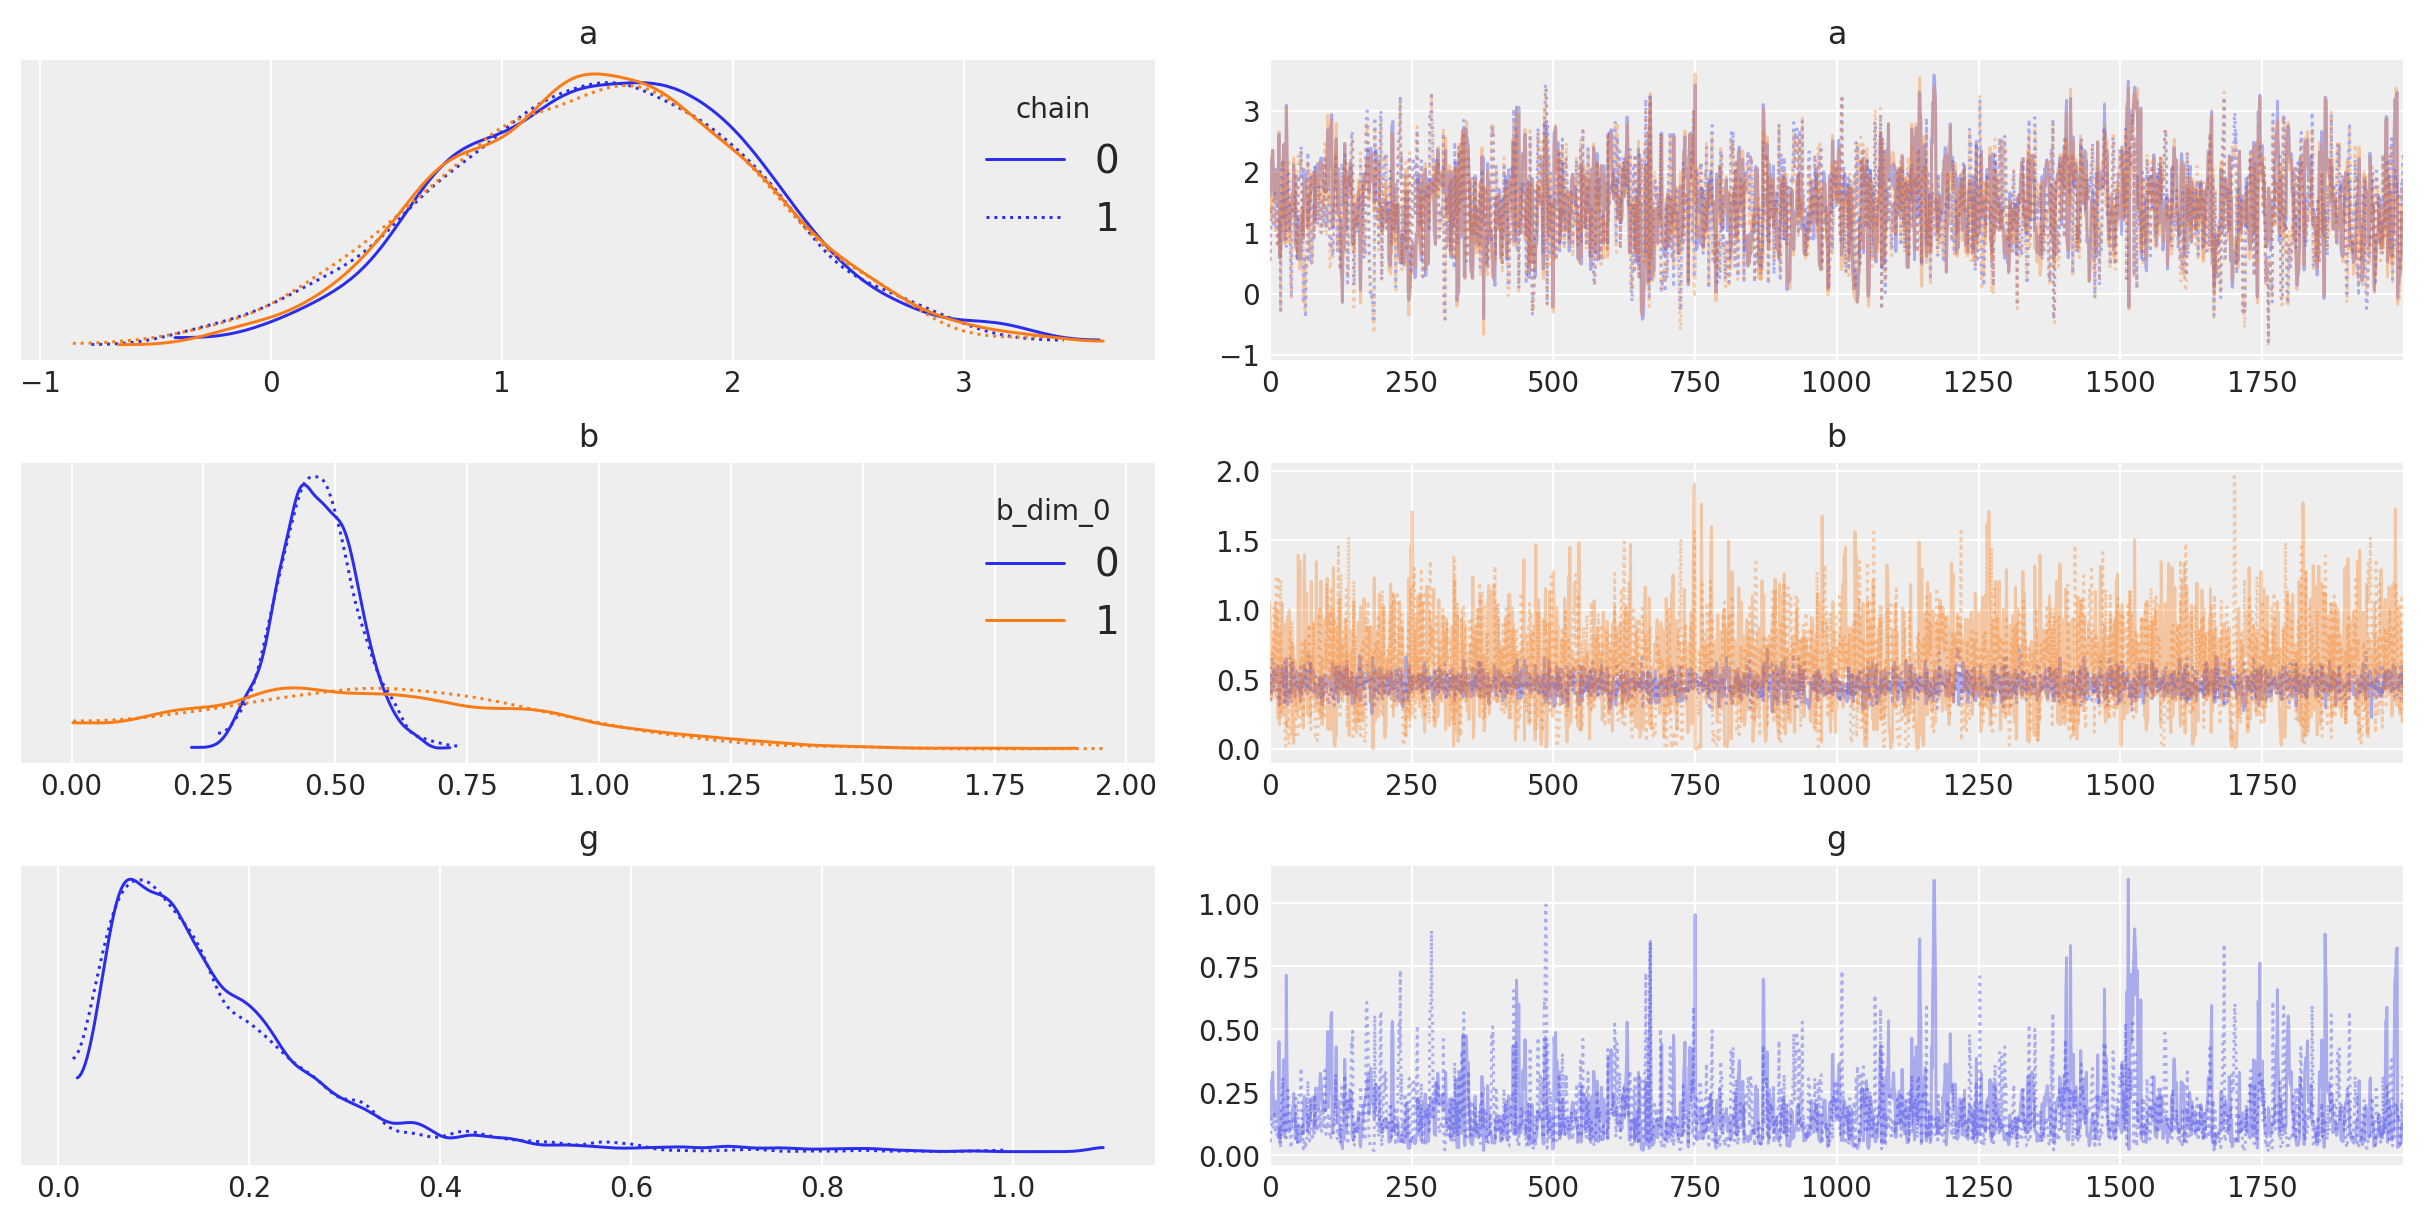

In [ ]:
az.plot_trace(idata_Pois, compact=True,legend= True);

##### prior predictive of Poisson model

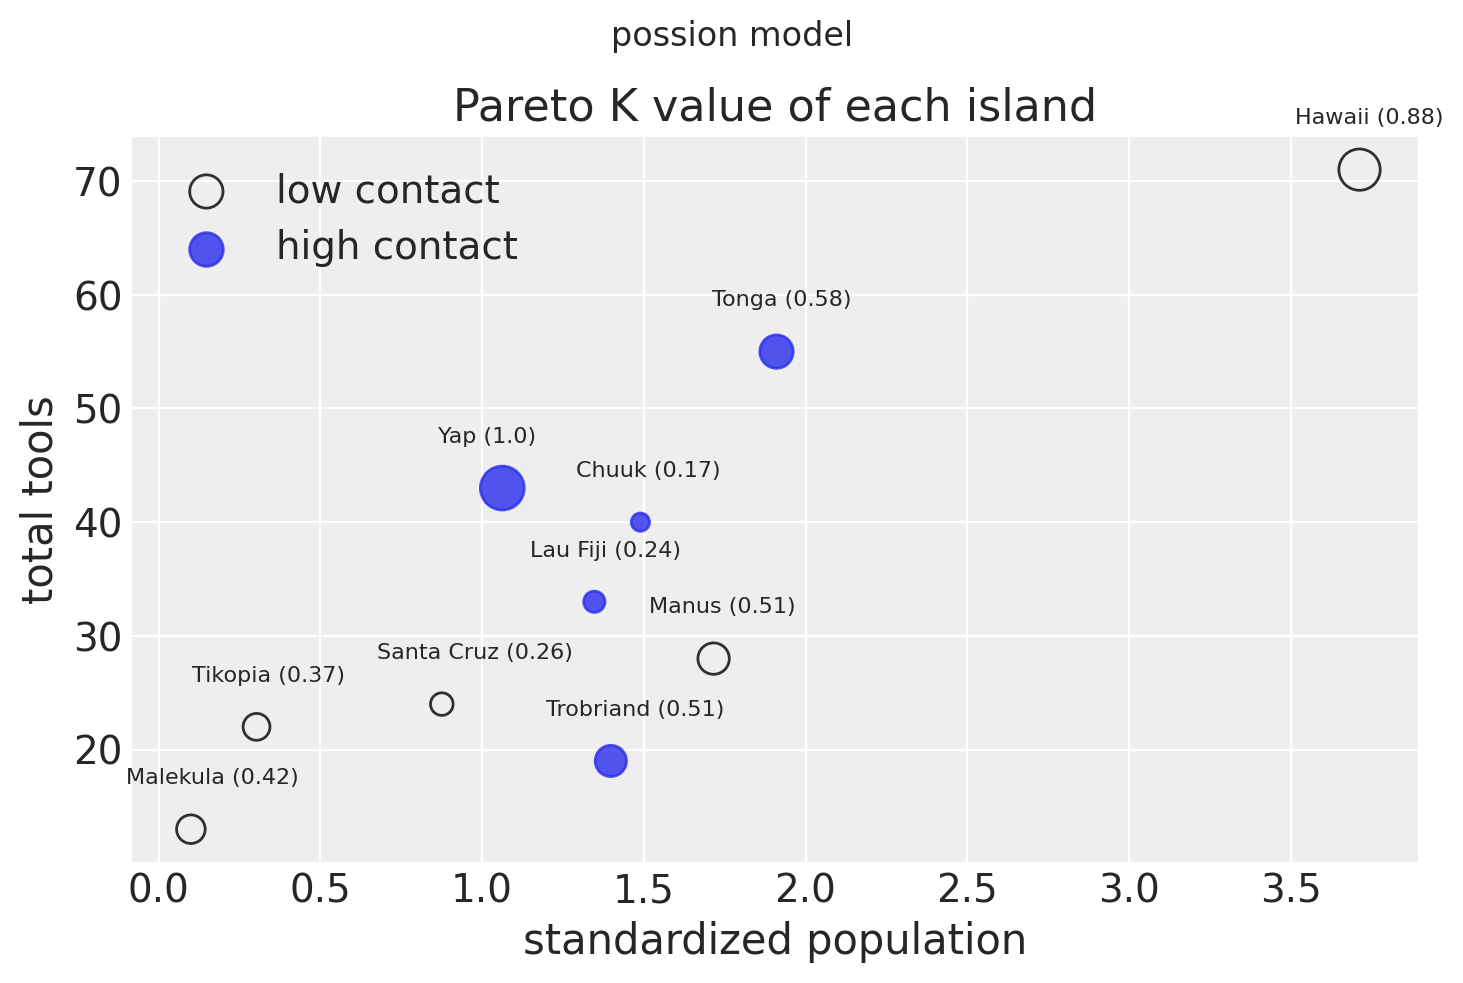

In [ ]:
k_pois = az.loo(idata_Pois, pointwise=True).pareto_k.values
k_pois /= k_pois.max()
psize_pois = 250 * k_pois

# display names and k_pois:
mask = k_pois > 0
labels = dk.culture.values[mask]
for i, text in enumerate(labels):
    plt.text(
        P[mask][i] - 0.2,
        dk.total_tools.values[mask][i] + 4,
        f"{text} ({np.round(k_pois[mask][i], 2)})",
        fontsize=8,
    )

# display observed data:
index = c_id == 1
plt.scatter(
    P[~index],
    dk.total_tools[~index],
    s=psize_pois[~index],
    facecolors="none",
    edgecolors="k",
    alpha=0.8,
    lw=1,
    label="low contact",
)
plt.scatter(P[index], dk.total_tools[index], s=psize_pois[index], alpha=0.8, label="high contact")
plt.xlabel('standardized population')
plt.ylabel('total tools')
plt.title('Pareto K value of each island')
plt.suptitle('possion model')
plt.legend()

Plotting the prior and prior predictives shows that our prior is probably not too narrow.

In [ ]:
ns = 100
P_seq = np.linspace(-1.4, 3.0, ns) + 1.4  # our little trick
with m_Pois:
    # predictions for cid=0 (low contact)
    pm.set_data({"cid": np.array([0] * ns), "P": P_seq})
    lam3 = pm.sample_prior_predictive(random_seed=RANDOM_SEED)
    lam3  = lam3["prior_predictive"]["total_tools"]

    # predictions for cid=1 (high contact)
    pm.set_data({"cid": np.array([1] * ns)})
    lam4 = pm.sample_prior_predictive(random_seed=RANDOM_SEED)
    lam4  = lam4["prior_predictive"]["total_tools"]
lmu3, lmu4 = lam3.mean(["chain", "draw"]), lam4.mean(["chain", "draw"])

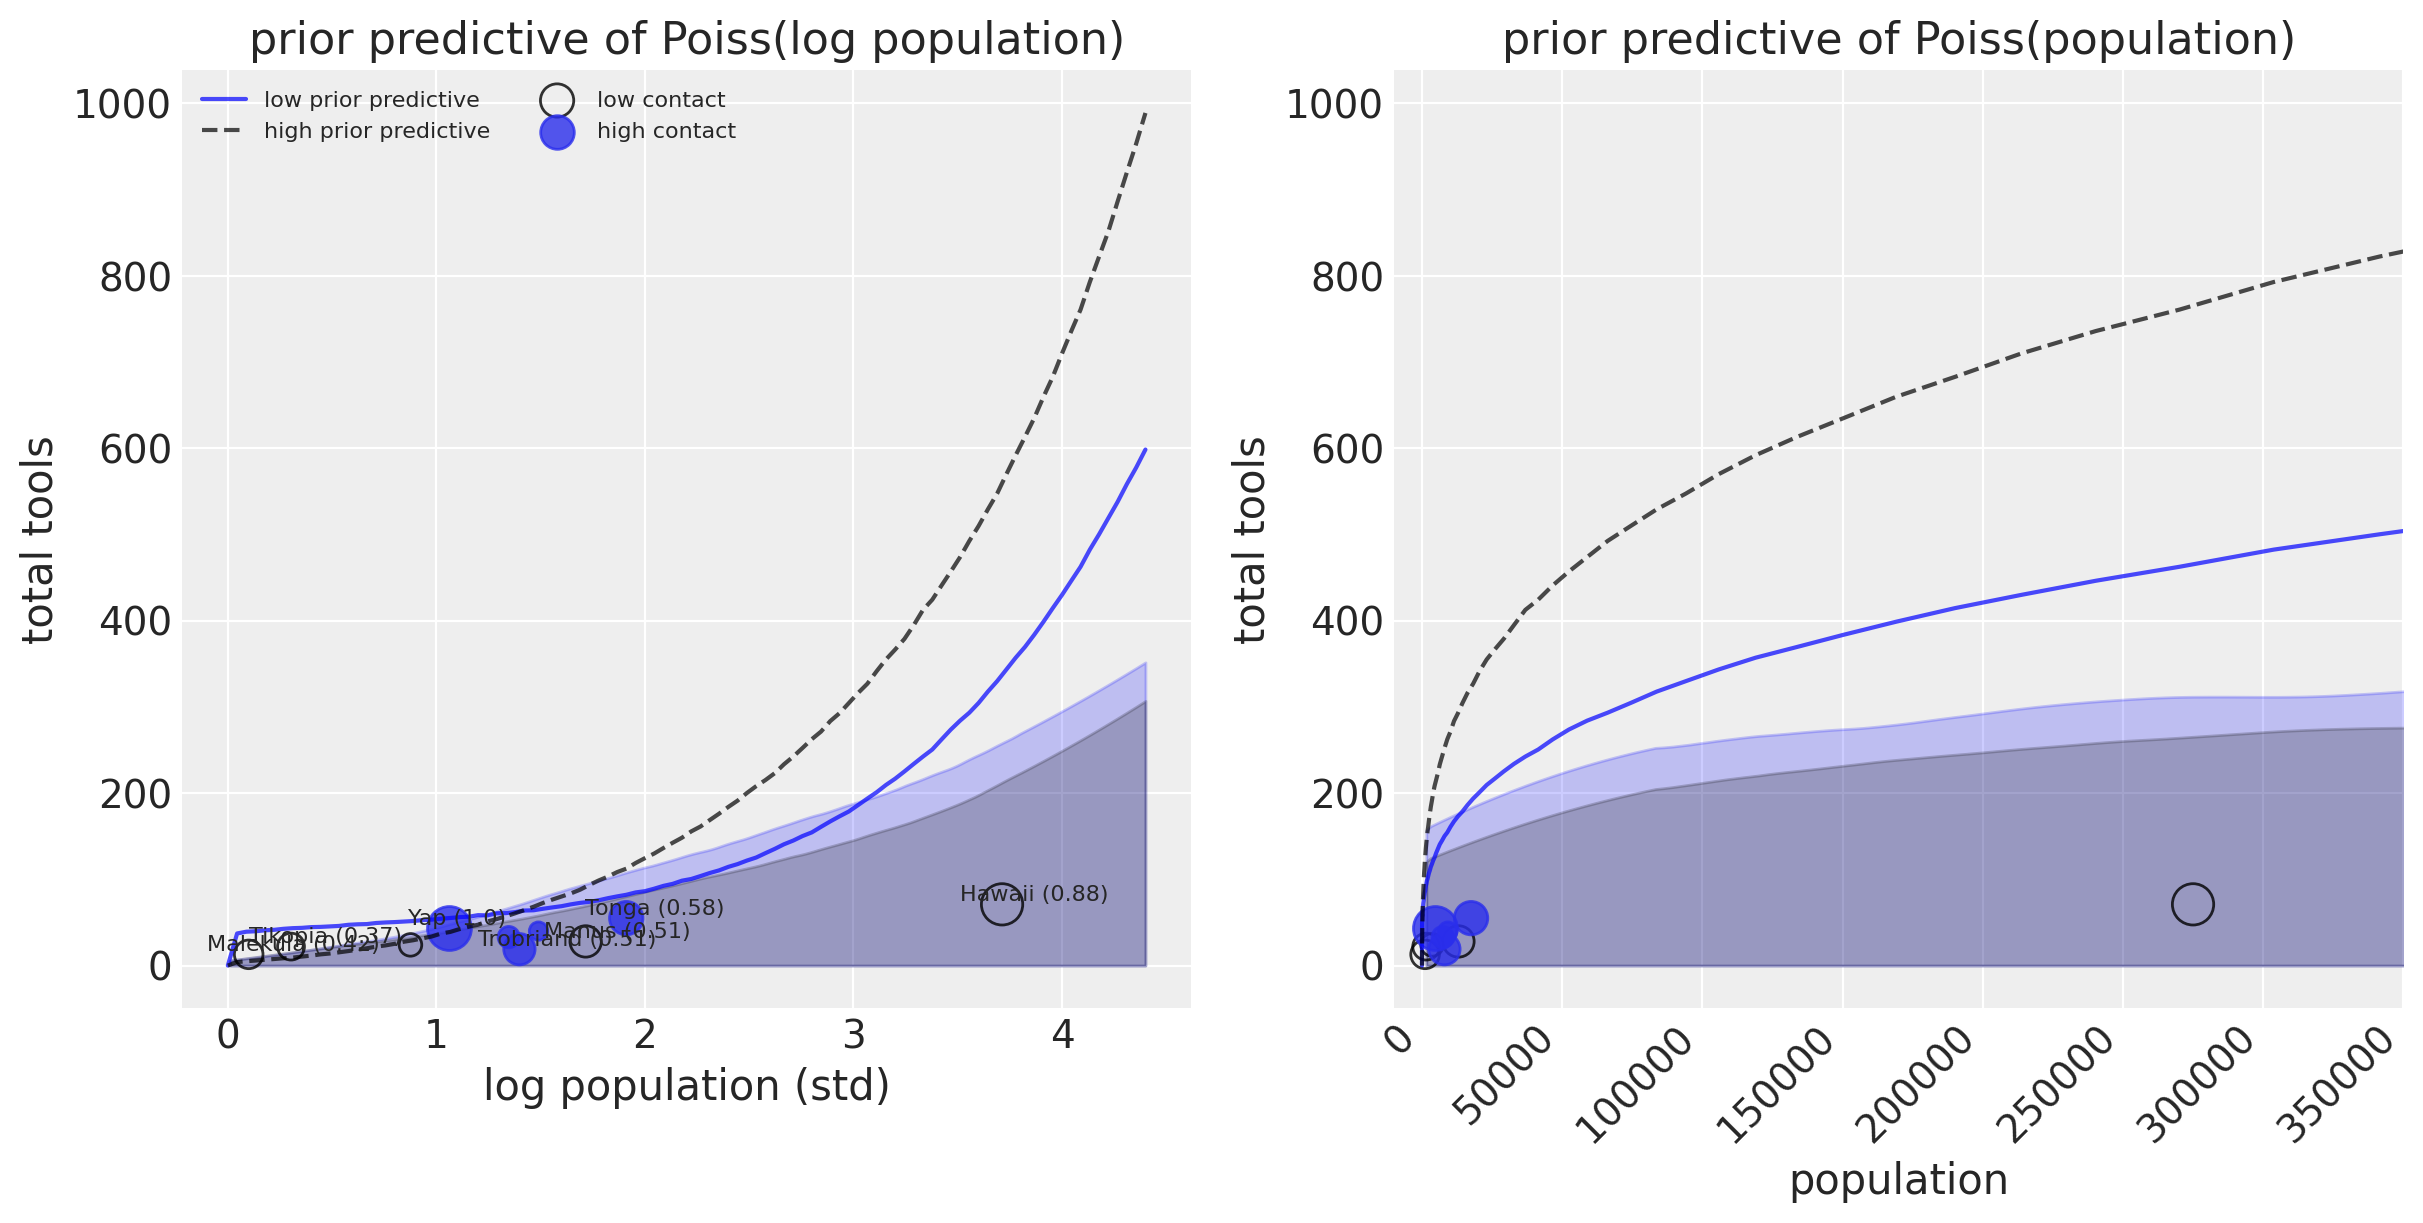

In [ ]:
ns = 100
P_seq = np.linspace(-1.4, 3.0, ns) + 1.4  # our little trick

_, (ax0, ax1) = plt.subplots(1, 2, figsize=(12, 6))

# Plot on standardized log scale:
P_seq = np.linspace(-1.4, 3.0, ns)+1.4
az.plot_hdi(P_seq, lam3, color="b", fill_kwargs={"alpha": 0.2}, ax=ax0)
ax0.plot(P_seq, lmu3, color="b", alpha=0.7, label="low prior predictive")


az.plot_hdi(P_seq, lam4, color="k", fill_kwargs={"alpha": 0.2}, ax=ax0)
ax0.plot(P_seq, lmu4, "--", color="k", alpha=0.7, label="high prior predictive")

# display names and k:
mask = k_pois > 0.3
labels = dk.culture.values[mask]
for i, text in enumerate(labels):
    ax0.text(
        P[mask][i] - 0.2,
        dk.total_tools.values[mask][i] + 4,
        f"{text} ({np.round(k_pois[mask][i], 2)})",
        fontsize=8,
    )

# display observed data:
index = c_id == 1
ax0.scatter(
    P[~index],
    dk.total_tools[~index],
    s=psize_pois[~index],
    facecolors="none",
    edgecolors="k",
    alpha=0.8,
    lw=1,
    label="low contact",
)

ax0.scatter(P[index], dk.total_tools[index], s=psize_pois[index], alpha=0.8, label="high contact")
ax0.set_xlabel("log population (std)")
ax0.set_ylabel("total tools")
ax0.legend(fontsize=8, ncol=2)
ax0.set_title("prior predictive of Poiss(log population)");

# Plot on natural scale:
# unstandardize and exponentiate values of standardized log pop:
P_seq = np.linspace(-5.0, 3.0, ns)
P_seq = np.exp(P_seq * np.log(dk.population.values).std() + np.log(dk.population.values).mean())

az.plot_hdi(P_seq, lam3, color="b", fill_kwargs={"alpha": 0.2}, ax=ax1)
ax1.plot(P_seq, lmu3, color="b", alpha=0.7)

az.plot_hdi(P_seq, lam4, color="k", fill_kwargs={"alpha": 0.2}, ax=ax1)
ax1.plot(P_seq, lmu4, "--", color="k", alpha=0.7)

# display observed data:
ax1.scatter(
    dk.population[~index],
    dk.total_tools[~index],
    s=psize_pois[~index],
    facecolors="none",
    edgecolors="k",
    alpha=0.8,
    lw=1,
)
ax1.scatter(dk.population[index], dk.total_tools[index], s=psize_pois[index], alpha=0.8)
plt.setp(ax1.get_xticklabels(), ha="right", rotation=45)
ax1.set_xlim((-10_000, 350_000))
ax1.set_xlabel("population")
ax1.set_ylabel("total tools");
ax1.set_title("prior predictive of Poiss(population)");


##### Examine posterior of Poisson model

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f7bf0fd99a0>,
      dtype=object)

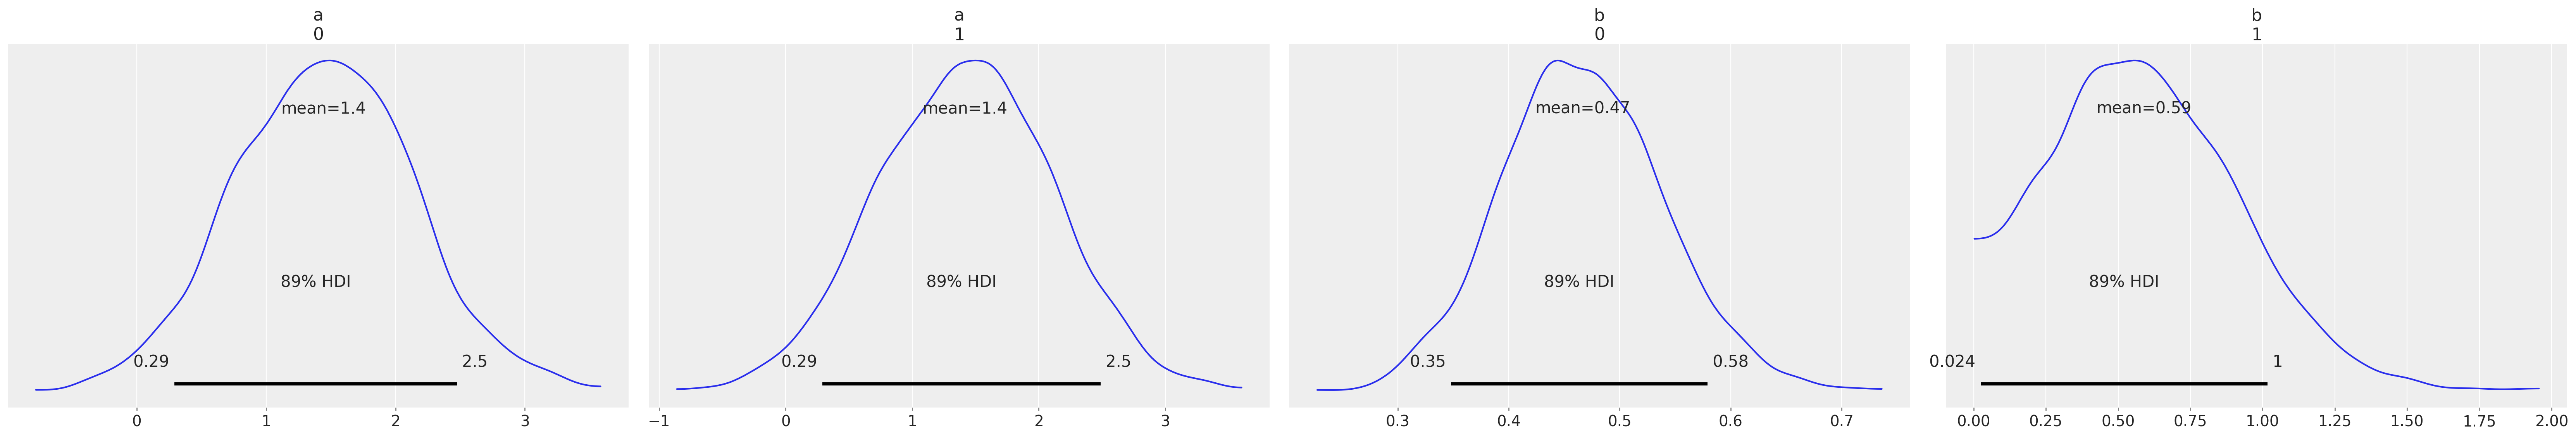

In [ ]:
az.plot_posterior(idata_Pois, var_names=["a","b"])


##### Posterior predictive of Poisson model

In [ ]:
ns = 100
P_seq = np.linspace(-1.4, 3.0, ns) + 1.4  # our little trick

with m_Pois:
    # predictions for cid=0 (low contact)
    pm.set_data({"cid": np.array([0] * ns), "P": P_seq})
    lam0 = pm.sample_posterior_predictive(idata_Pois, var_names=["total_tools"])[
        "posterior_predictive"
    ]["total_tools"]

    # predictions for cid=1 (high contact)
    pm.set_data({"cid": np.array([1] * ns)})
    lam1 = pm.sample_posterior_predictive(idata_Pois, var_names=["total_tools"])[
        "posterior_predictive"
    ]["total_tools"]

lmu0, lmu1 = lam0.mean(["chain", "draw"]), lam1.mean(["chain", "draw"])


Text(0.5, 1.0, 'posterior predictive of Poisson model(population)')

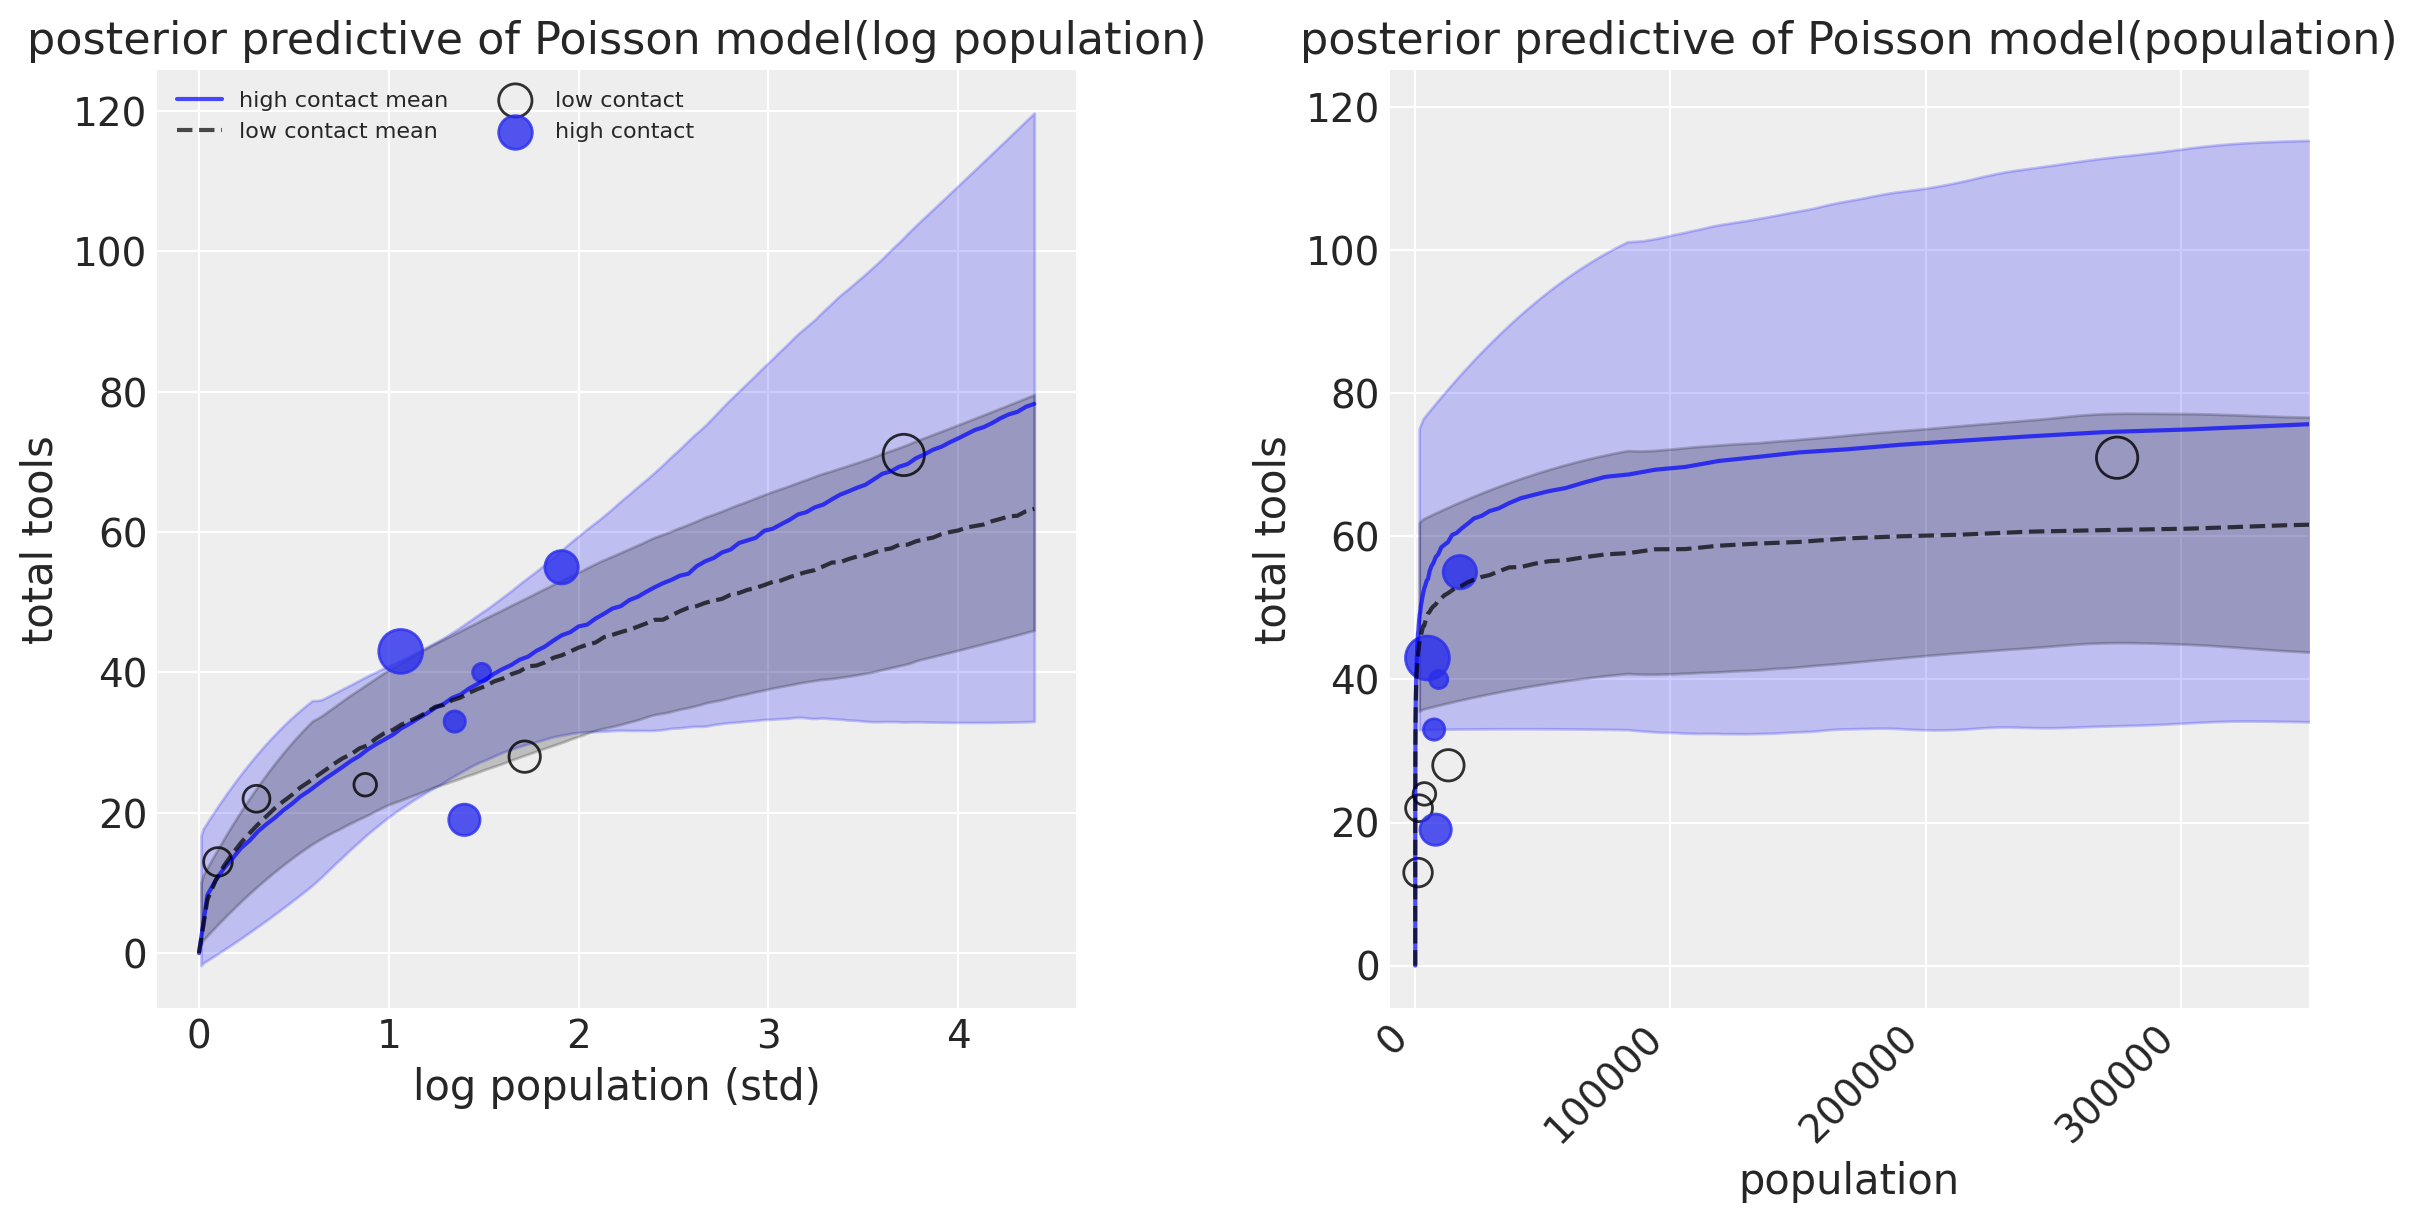

In [ ]:
_, (ax0, ax1) = plt.subplots(1, 2, figsize=(12, 6))
# Plot on standardized log scale:
P_seq = np.linspace(-1.4, 3.0, ns)+ 1.4
az.plot_hdi(P_seq, lam1, color="b", fill_kwargs={"alpha": 0.2}, ax=ax0)
ax0.plot(P_seq, lmu1, color="b", alpha=0.7, label="high contact mean")

az.plot_hdi(P_seq, lam0, color="k", fill_kwargs={"alpha": 0.2}, ax=ax0)
ax0.plot(P_seq, lmu0, "--", color="k", alpha=0.7, label="low contact mean")


# display observed data:
index = c_id == 1
ax0.scatter(
    P[~index],
    dk.total_tools[~index],
    s=psize_pois[~index],
    facecolors="none",
    edgecolors="k",
    alpha=0.8,
    lw=1,
    label="low contact",
)

ax0.scatter(P[index], dk.total_tools[index], s=psize_pois[index], alpha=0.8, label="high contact")
ax0.set_xlabel("log population (std)")
ax0.set_ylabel("total tools")
ax0.set_title("posterior predictive of Poisson model(log population)")
ax0.legend(fontsize=8, ncol=2)
# Plot on natural scale:
# unstandardize and exponentiate values of standardized log pop:
P_seq = np.linspace(-5.0, 3.0, ns)
P_seq = np.exp(P_seq * np.log(dk.population.values).std() + np.log(dk.population.values).mean())

az.plot_hdi(P_seq, lam1, color="b", fill_kwargs={"alpha": 0.2}, ax=ax1)
ax1.plot(P_seq, lmu1, color="b", alpha=0.7)

az.plot_hdi(P_seq, lam0, color="k", fill_kwargs={"alpha": 0.2}, ax=ax1)
ax1.plot(P_seq, lmu0, "--", color="k", alpha=0.7)


# display observed data:
ax1.scatter(
    dk.population[~index],
    dk.total_tools[~index],
    s=psize_pois[~index],
    facecolors="none",
    edgecolors="k",
    alpha=0.8,
    lw=1,
)

ax1.scatter(dk.population[index], dk.total_tools[index], s=psize_pois[index], alpha=0.8)
plt.setp(ax1.get_xticklabels(), ha="right", rotation=45)
ax1.set_xlim((-10_000, 350_000))
ax1.set_xlabel("population")
ax1.set_ylabel("total tools");
ax1.set_title("posterior predictive of Poisson model(population)")

##### Diagnostics of Poisson model

In [ ]:
az.summary(idata_Pois, kind="diagnostics")


mcse_mean  mcse_sd  ess_bulk  ess_tail  r_hat
a[0]      0.022    0.016     923.0    1090.0    1.0
a[1]      0.022    0.016     944.0    1086.0    1.0
b[0]      0.002    0.001    1951.0    1944.0    1.0
b[1]      0.007    0.005    1733.0     920.0    1.0
g         0.004    0.003     926.0    1028.0    1.0

#### Gaussian model

##### Exponential guaderic kernel model

In [ ]:
with pm.Model() as m_GEQ:
    a = pm.Exponential("a", 1.0)
    b = pm.Exponential("b", 1.0)
    g = pm.Exponential("g", 1.0)

    etasq = pm.Exponential("etasq", 2.0)
    ls_inv = pm.HalfNormal("ls_inv", 2.0)
    rhosq = pm.Deterministic("rhosq", 0.5 * ls_inv**2)

    # Implementation with PyMC's GP module:
    cov = etasq * pm.gp.cov.ExpQuad(input_dim=1, ls_inv=ls_inv)
    gp = pm.gp.Latent(cov_func=cov)
    k = gp.prior("k", X=Dmat)

    lam = (a * P**b / g) * at.exp(k[society])

    T = pm.Poisson("total_tools", lam, observed=total_tools)

    idata_GEQ = pm.sample(4000, tune=2000, target_accept=0.99, random_seed=RANDOM_SEED)
    trace_GEQ = idata_GEQ.posterior

See the plot of relationship of standardized population、total tools、Pareto k of each island

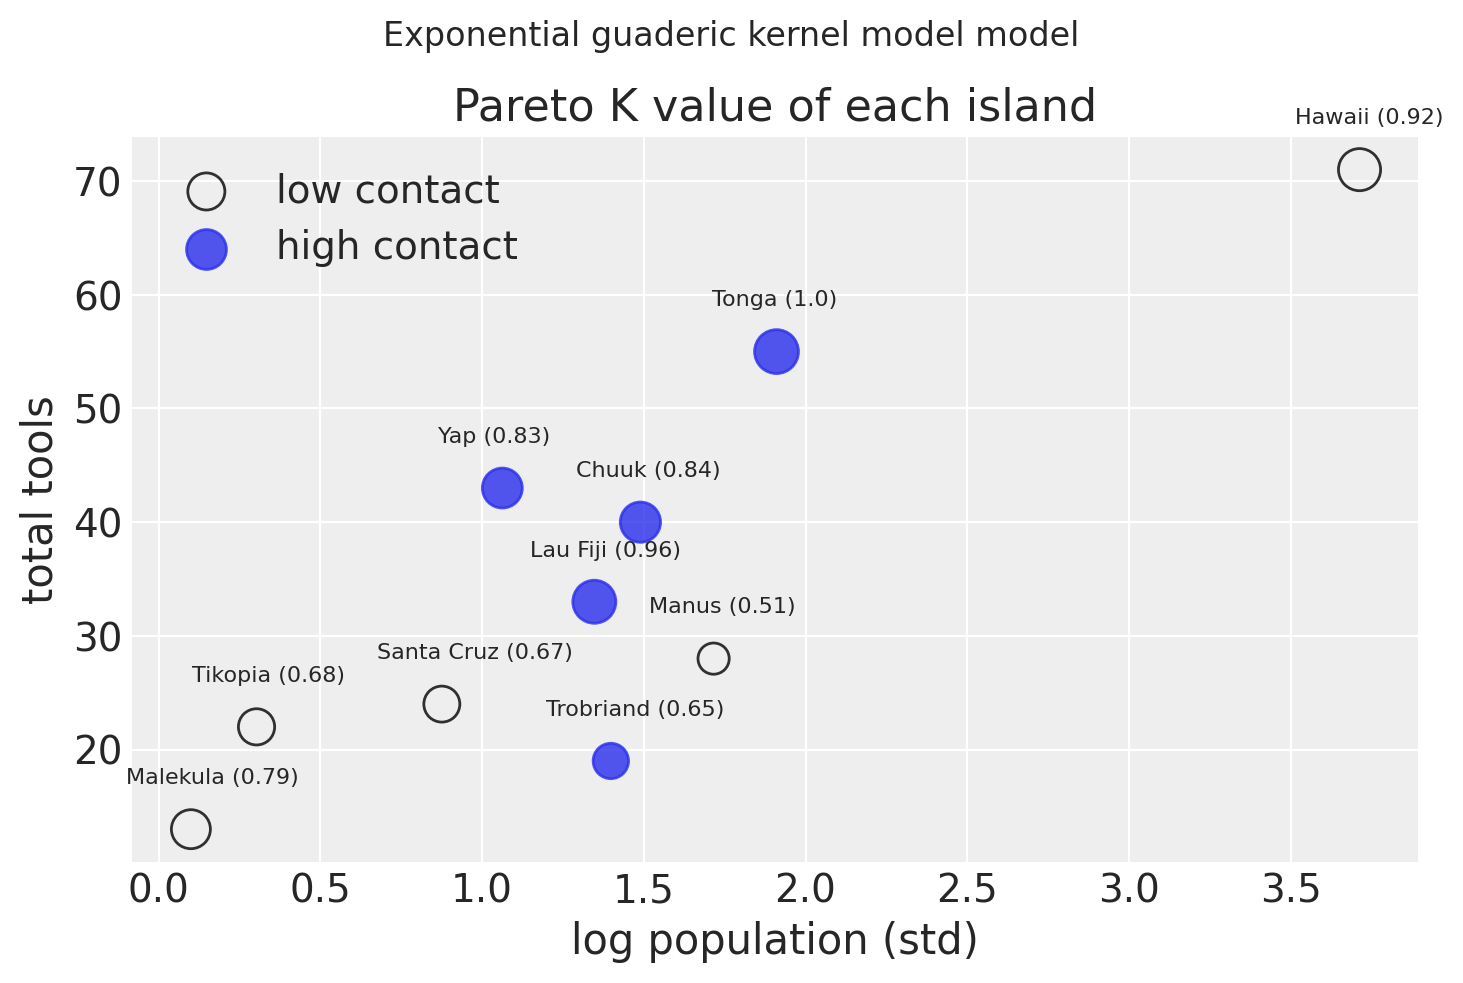

In [ ]:
k = az.loo(idata_GEQ, pointwise=True).pareto_k.values
k /= k.max()
psize = 250 * k

# display names and k:
mask = k > 0.3
labels = dk.culture.values[mask]
for i, text in enumerate(labels):
    plt.text(
        P[mask][i] - 0.2,
        dk.total_tools.values[mask][i] + 4,
        f"{text} ({np.round(k[mask][i], 2)})",
        fontsize=8,
    )

# display observed data:
index = c_id == 1
plt.scatter(
    P[~index],
    dk.total_tools[~index],
    s=psize[~index],
    facecolors="none",
    edgecolors="k",
    alpha=0.8,
    lw=1,
    label="low contact",
)
plt.scatter(P[index], dk.total_tools[index], s=psize[index], alpha=0.8, label="high contact")
plt.xlabel('log population (std)')
plt.ylabel('total tools')
plt.title('Pareto K value of each island')
plt.suptitle('Exponential guaderic kernel model model')
plt.legend()

###### prior predictive of Exponential guaderic kernel model

In [ ]:
idata_G = pm.sample_prior_predictive(samples=1000, model=m_GEQ)
# compute posterior median covariance
x_seq = np.linspace(0, 10, 100)
postG = idata_G.prior.stack(sample=("chain", "draw"))
pmcov_mu_G = postG["etasq"].median().values * np.exp(-postG["rhosq"].median().values * (x_seq**2))
# compute posterior median covariance among societies
K_G = postG["etasq"].median().values * np.exp(-postG["rhosq"].median().values * Dmatsq) + np.diag(
    [0.01] * Nsociety
)
# convert to correlation matrix
sigma_postG = np.sqrt(np.diag(K_G))
Rho_G = (sigma_postG**-1) * K_G * (sigma_postG**-1)

# add row/col names for convenience
Rho_G = pd.DataFrame(
    Rho_G,
    index=["Ml", "Ti", "SC", "Ya", "Fi", "Tr", "Ch", "Mn", "To", "Ha"],
    columns=["Ml", "Ti", "SC", "Ya", "Fi", "Tr", "Ch", "Mn", "To", "Ha"],
)

Rho_G.round(2)

Ml    Ti    SC    Ya    Fi    Tr    Ch    Mn    To   Ha
Ml  1.00  0.79  0.68  0.00  0.25  0.02  0.00  0.00  0.04  0.0
Ti  0.79  1.00  0.89  0.00  0.25  0.03  0.00  0.00  0.03  0.0
SC  0.68  0.89  1.00  0.00  0.11  0.07  0.00  0.01  0.01  0.0
Ya  0.00  0.00  0.00  1.00  0.00  0.00  0.11  0.09  0.00  0.0
Fi  0.25  0.25  0.11  0.00  1.00  0.00  0.00  0.00  0.58  0.0
Tr  0.02  0.03  0.07  0.00  0.00  1.00  0.05  0.51  0.00  0.0
Ch  0.00  0.00  0.00  0.11  0.00  0.05  1.00  0.26  0.00  0.0
Mn  0.00  0.00  0.01  0.09  0.00  0.51  0.26  1.00  0.00  0.0
To  0.04  0.03  0.01  0.00  0.58  0.00  0.00  0.00  1.00  0.0
Ha  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  1.0

Text(0.5, 1.0, 'Geographic covanriance')

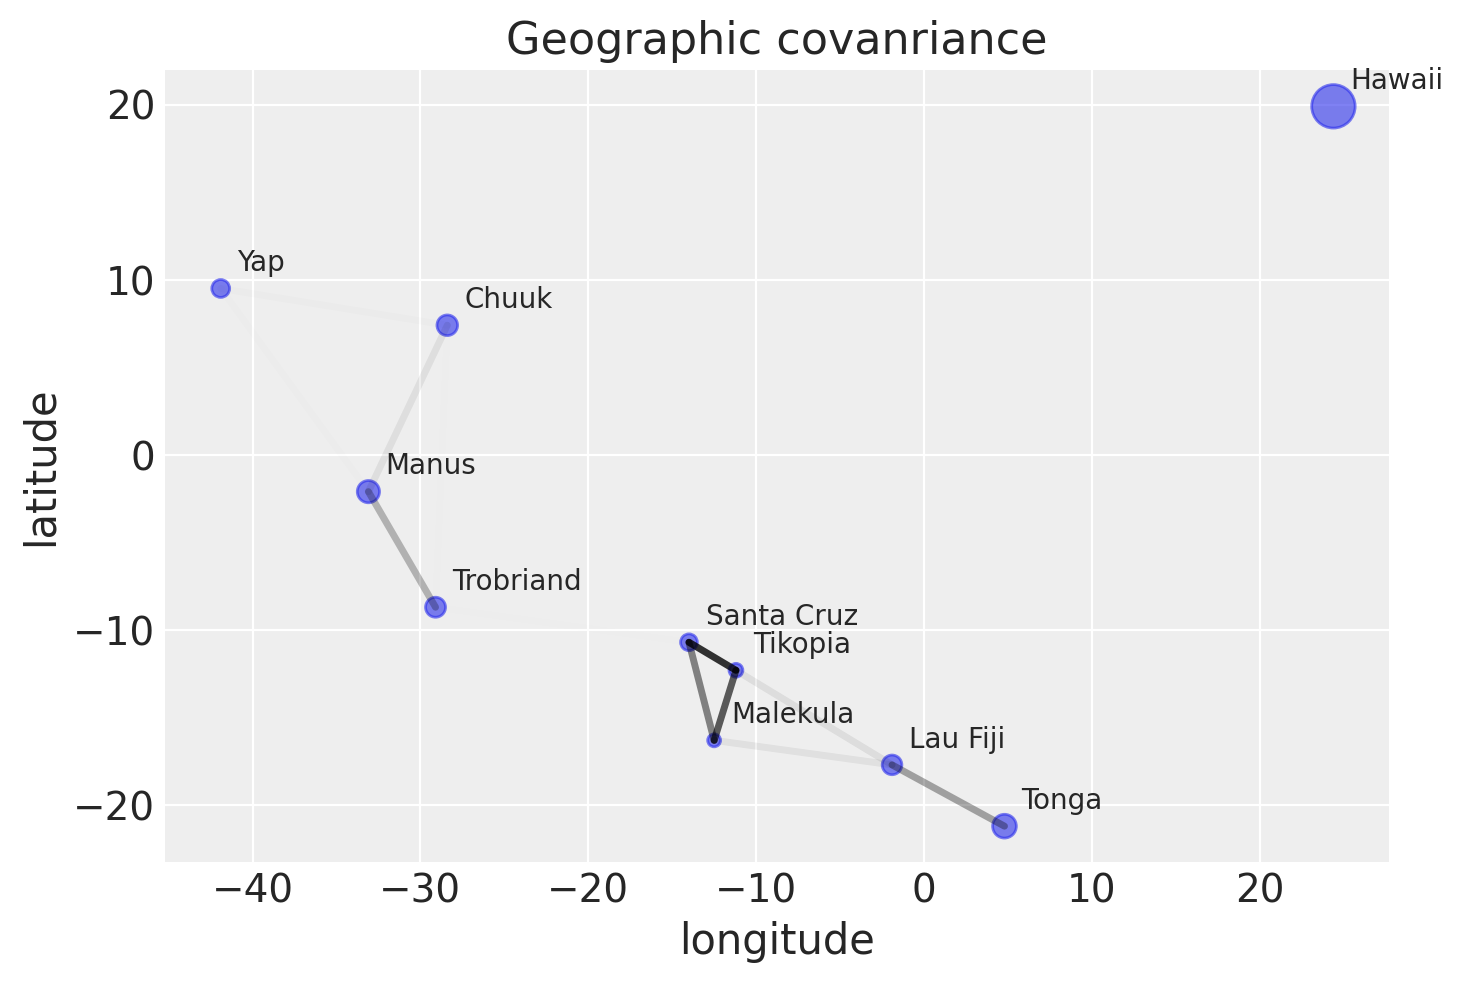

In [ ]:
# Code 14.44
# scale point size to logpop
logpop = np.copy(dk["logpop"].values)
logpop /= logpop.max()
psize = np.exp(logpop * 5.5)

_, (ax0) = plt.subplots(1,constrained_layout=True)

# plot raw data and labels
ax0.scatter(dk["lon2"], dk["lat"], psize, alpha=0.6)
labels = dk["culture"].values
for i, itext in enumerate(labels):
    ax0.text(dk["lon2"][i] + 1, dk["lat"][i] + 1, itext)

# overlay lines shaded by Rho
for i in range(10):
    for j in np.arange(i + 1, 10):
        ax0.plot(
            [dk["lon2"][i], dk["lon2"][j]],
            [dk["lat"][i], dk["lat"][j]],
            "k-",
            alpha=Rho_G.iloc[i, j] ** 2,
            lw=2.5,
        )

ax0.set_xlabel("longitude")
ax0.set_ylabel("latitude")
ax0.set_title("Geographic covanriance")


In [ ]:
PPGG = idata_G.prior_predictive["total_tools"]

Text(0.5, 1.0, 'prior predictive tatol tools of each island \nsorted by population ')

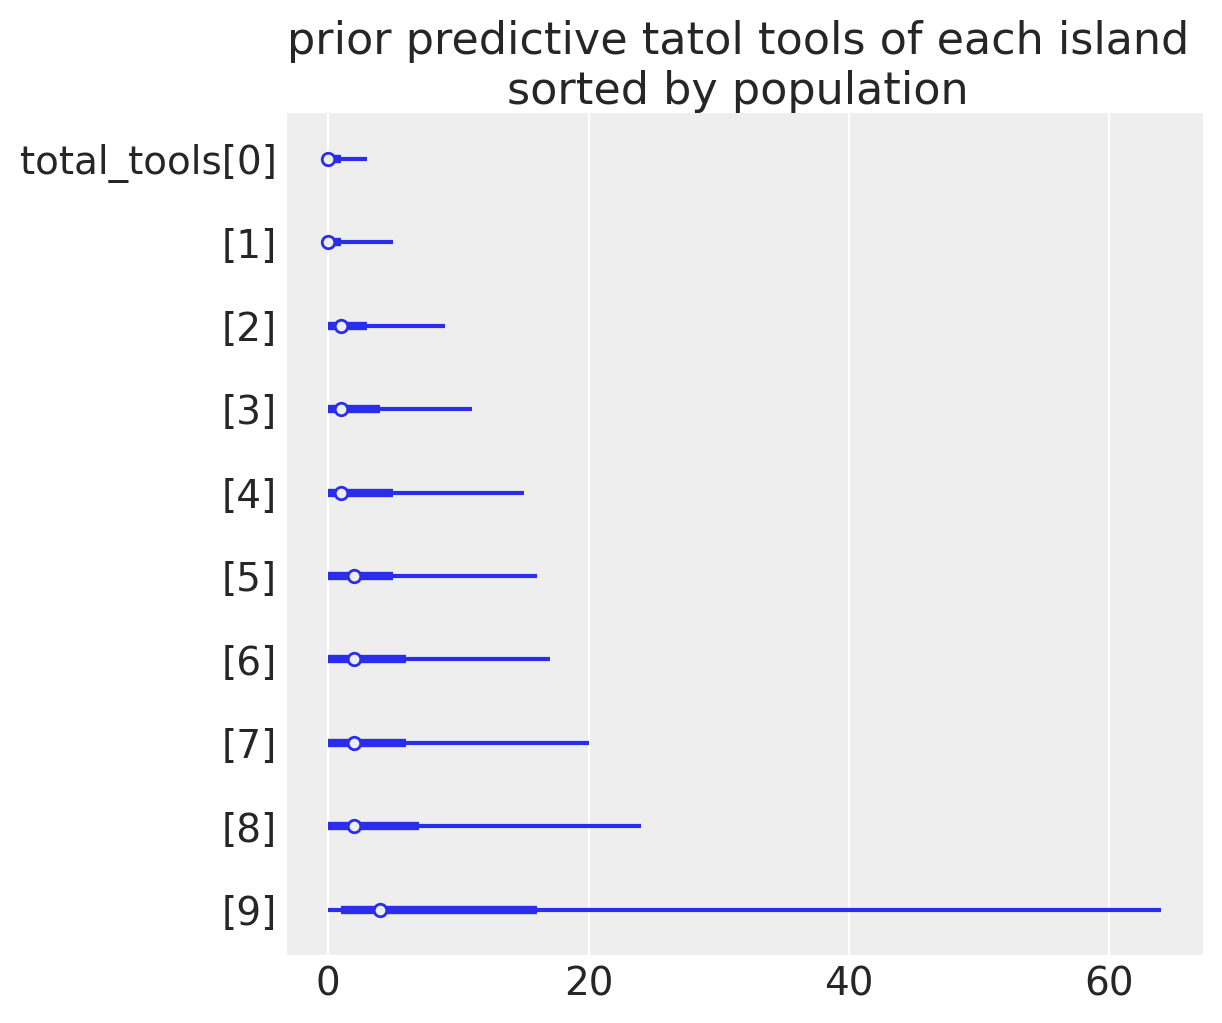

In [ ]:
axes = az.plot_forest(PPGG, var_names=["total_tools"])
axes[0].set_title("prior predictive tatol tools of each island \nsorted by population ")

###### posterior of Exponential guaderic kernel model

To get the posterior median covariance of distance

In [ ]:
# compute posterior median covariance
x_seq = np.linspace(0, 10, 100)
post = idata_GEQ.posterior.stack(sample=("chain", "draw"))    #posterior of m_GEQ
pmcov_mu = post["etasq"].median().values * np.exp(-post["rhosq"].median().values * (x_seq**2))

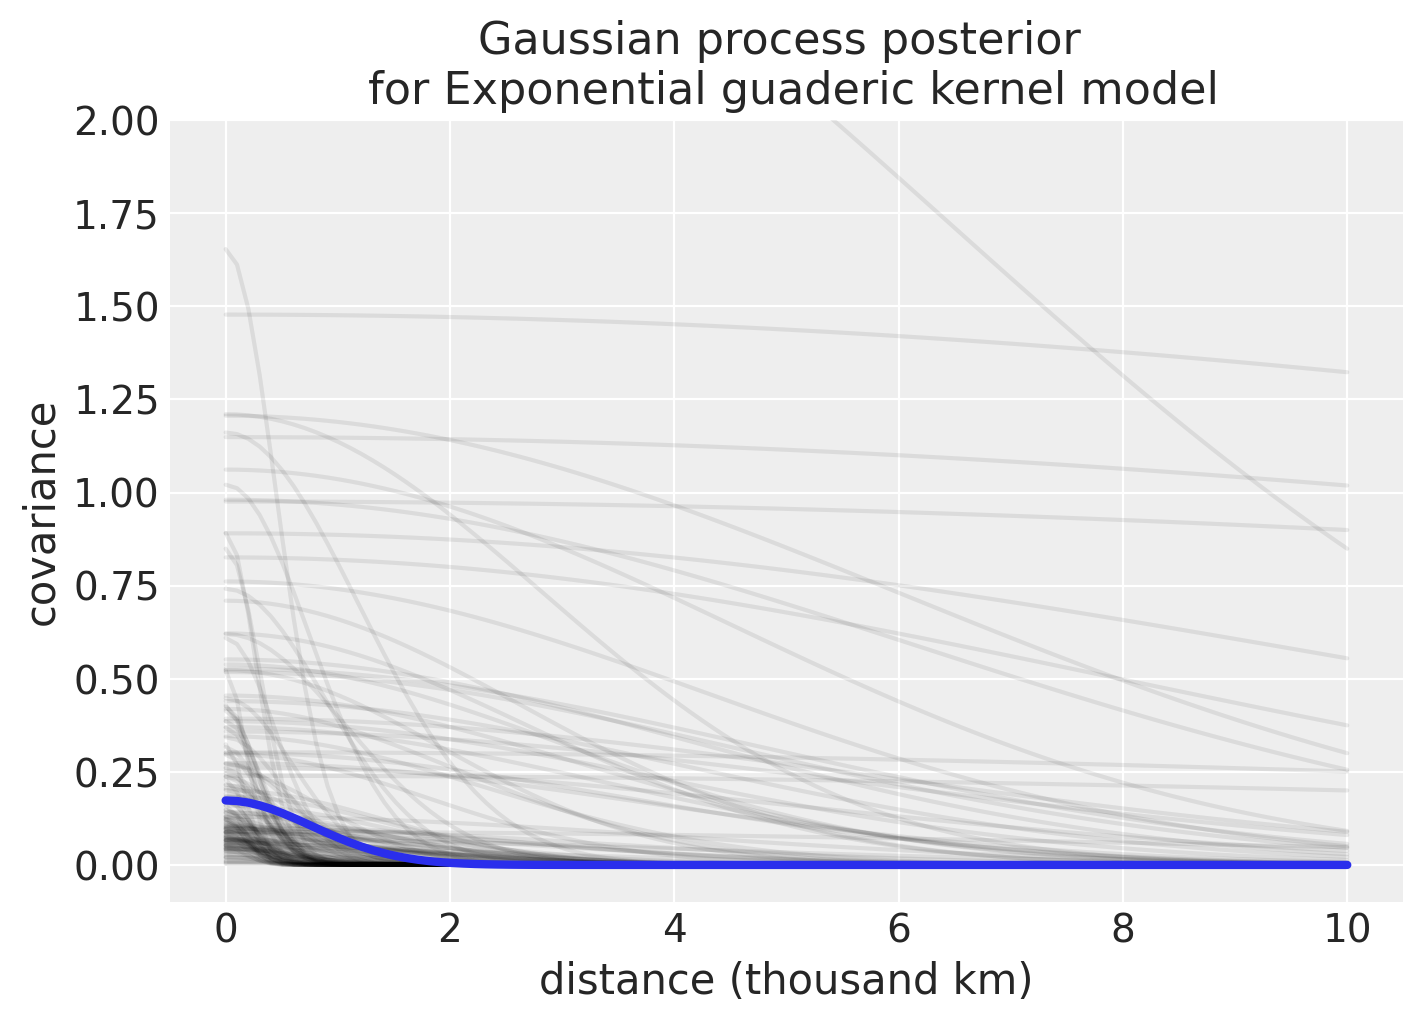

In [169]:
_, ax = plt.subplots(1, 1, figsize=(7, 5))

# plot functions sampled from posterior
ax.plot(
    x_seq,
    (
        post["etasq"][::50].values[:, None]
        * np.exp(-post["rhosq"][::50].values[:, None] * (x_seq**2))
    ).T,
    "k",
    alpha=0.08,
)

# plot median covariance function
ax.plot(x_seq, pmcov_mu, lw=3)

ax.set(
    title="Gaussian process posterior \n for Exponential guaderic kernel model",
    ylim=(-0.1, 2),
    xlabel="distance (thousand km)",
    ylabel="covariance",
);

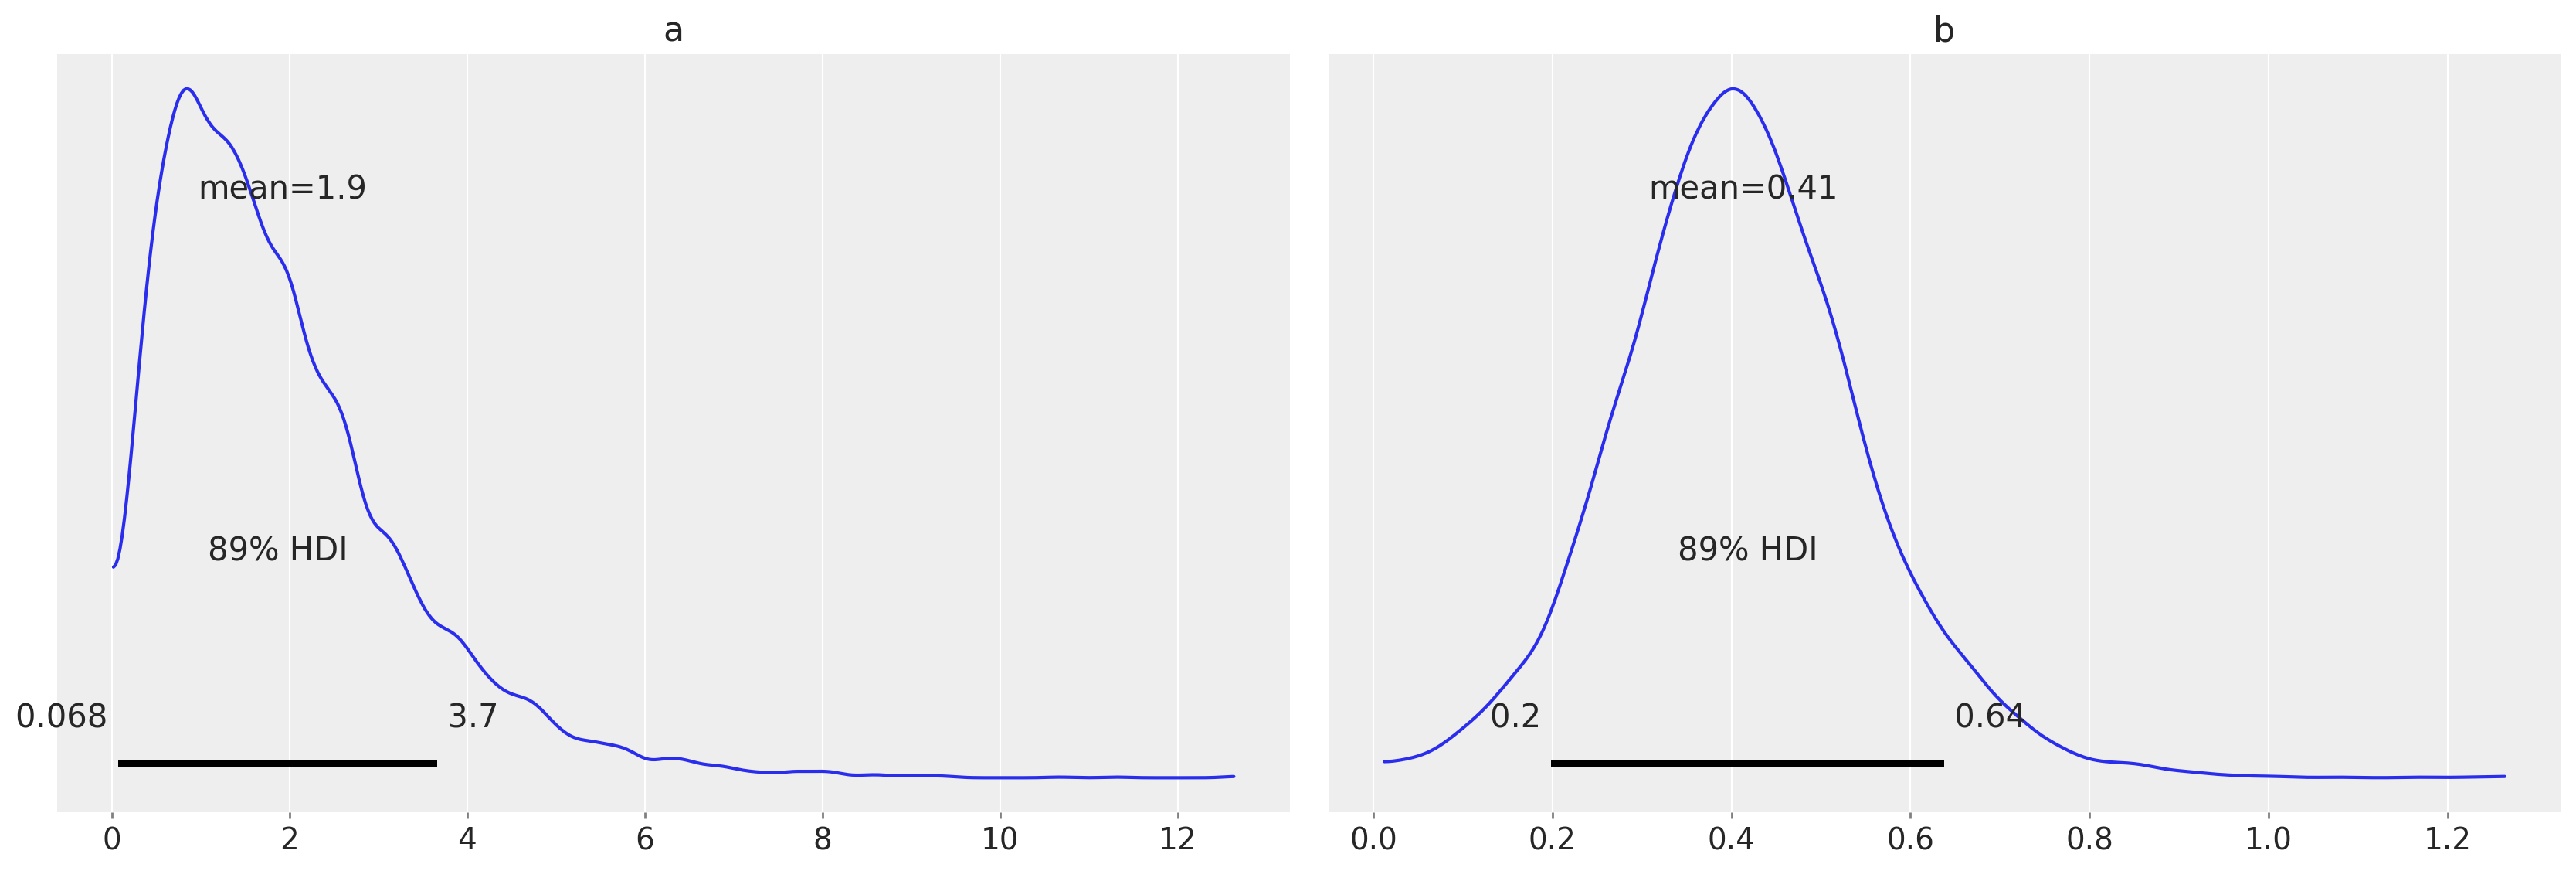

In [ ]:
az.plot_posterior(idata_GEQ, var_names=["a","b"])

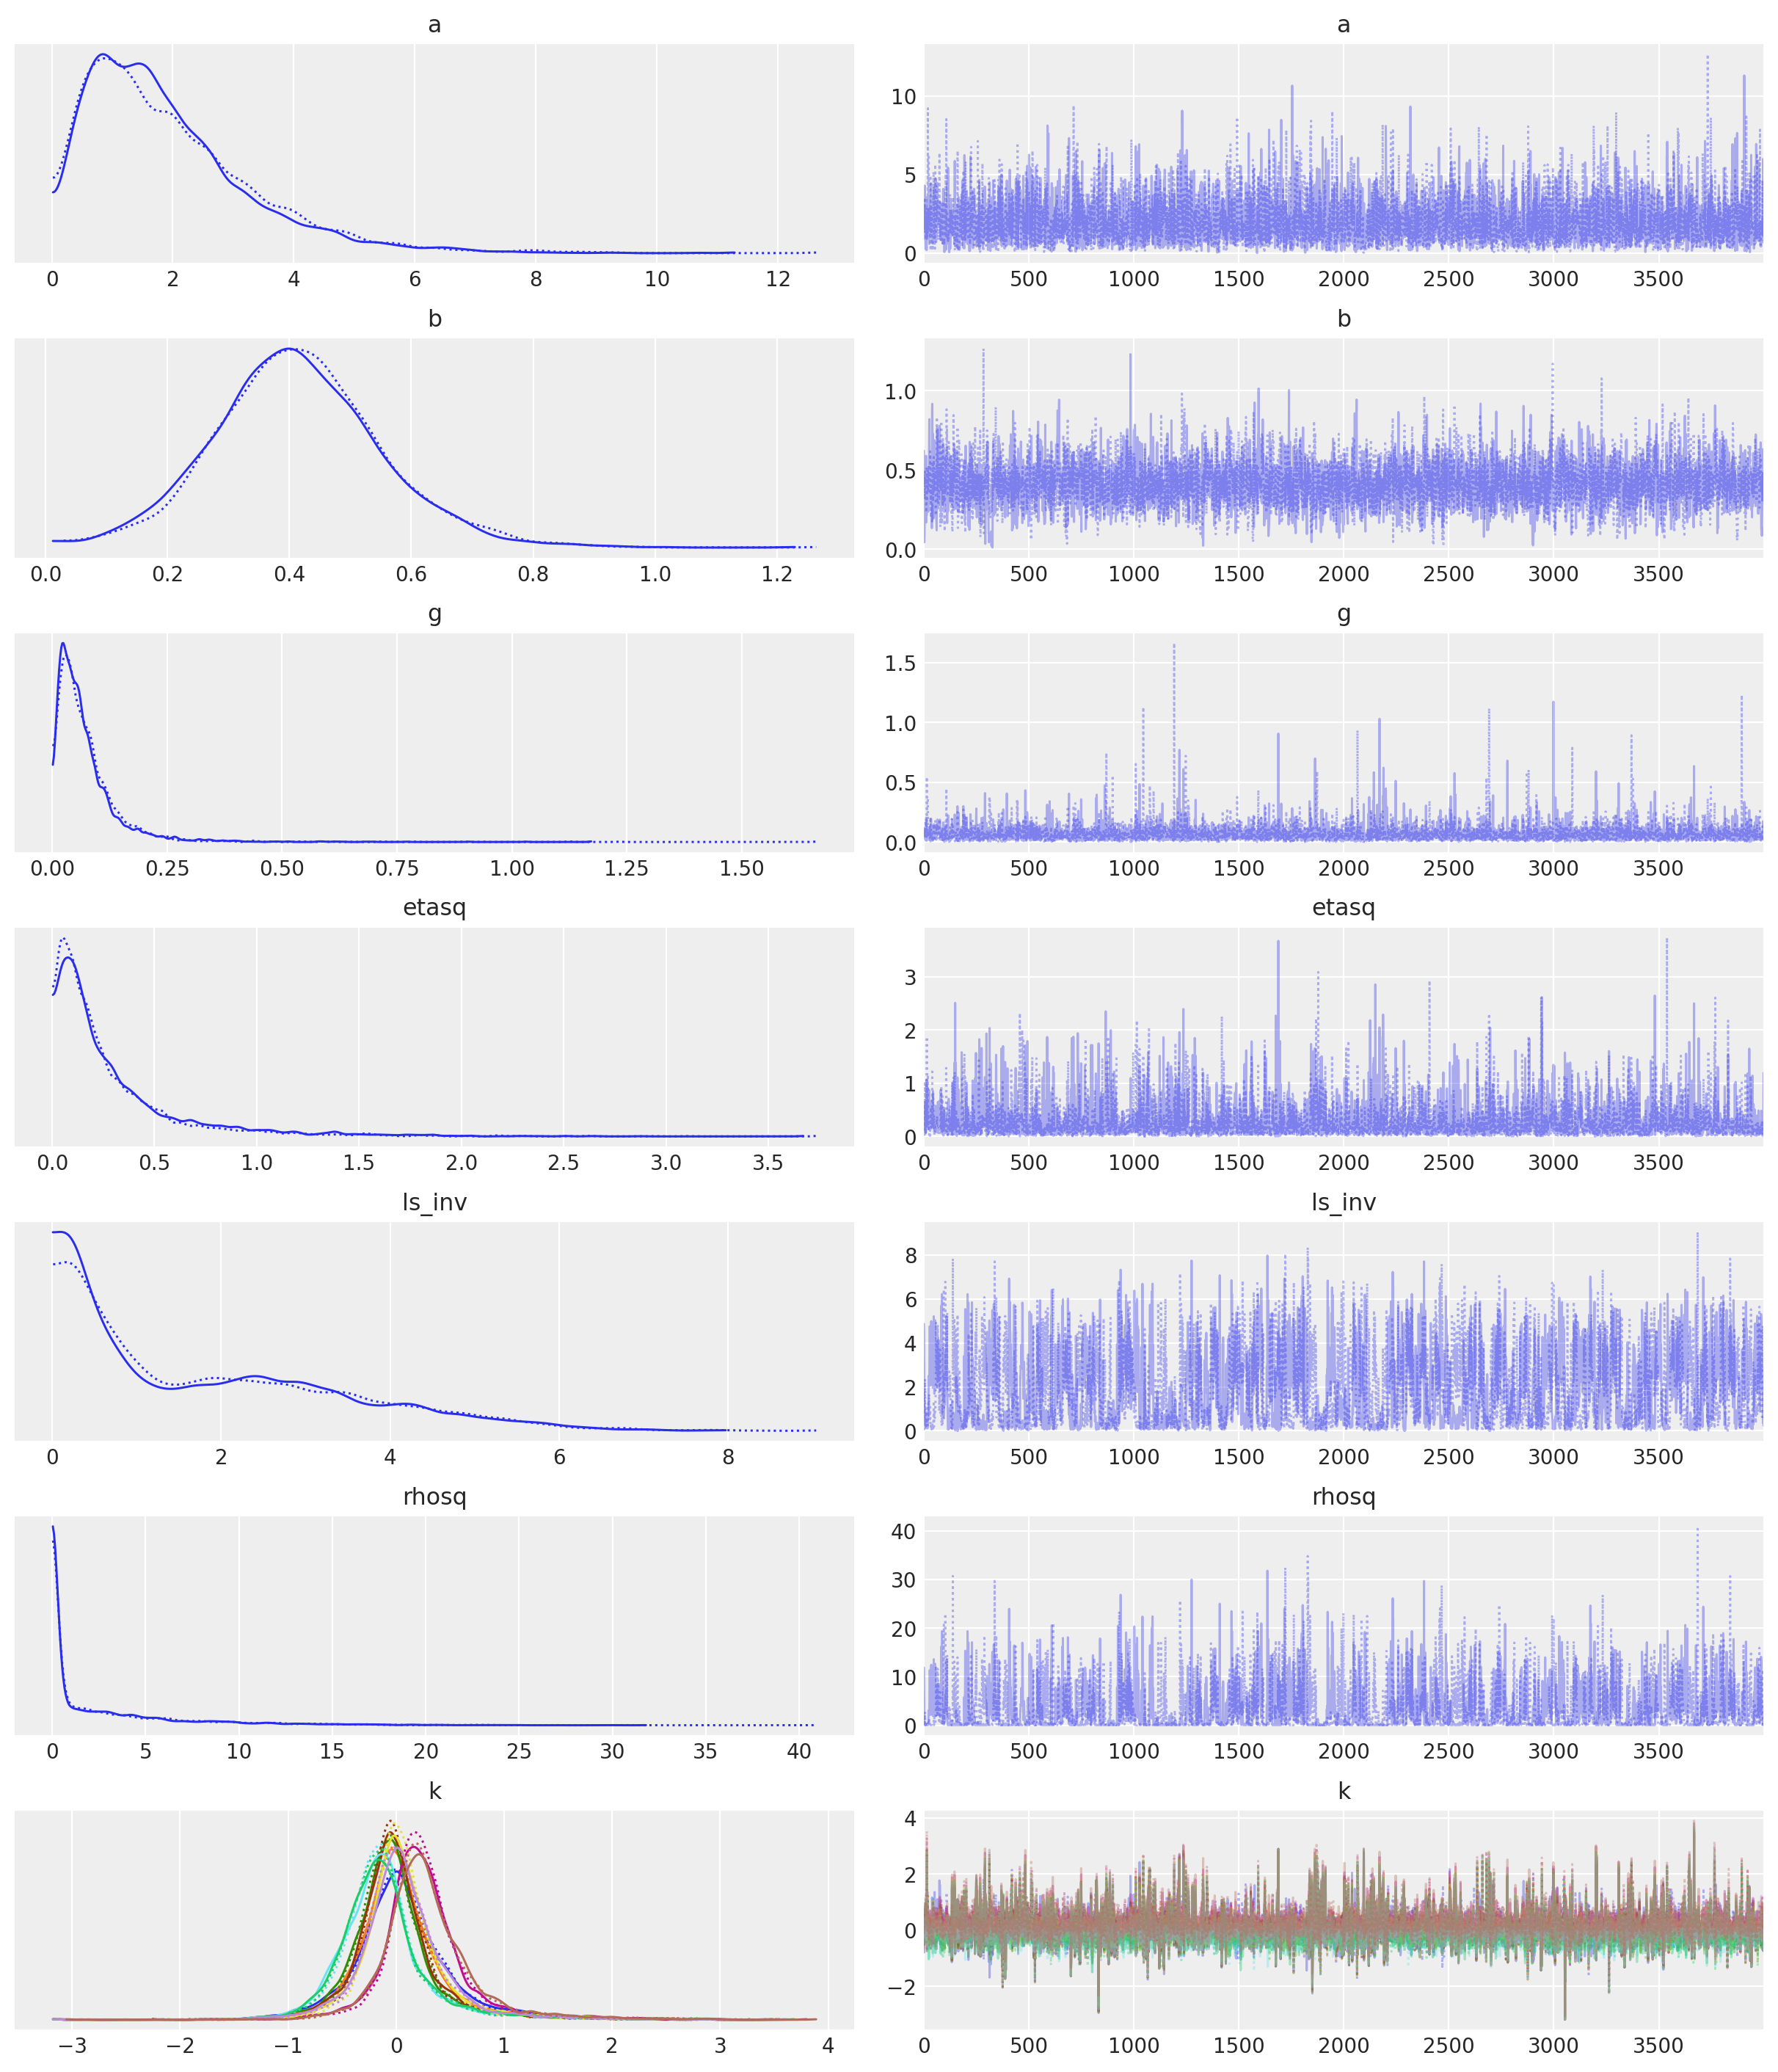

In [ ]:
az.plot_trace(idata_GEQ, var_names=["~k_rotated_"], compact=True);

###### posterior predictive of Exponential guaderic kernel model

In [ ]:
# compute posterior median covariance among societies of m_GEQ
K = post["etasq"].median().values * np.exp(-post["rhosq"].median().values * Dmatsq) + np.diag(
    [0.01] * Nsociety
)
# convert to correlation matrix
sigma_post = np.sqrt(np.diag(K))
Rho = (sigma_post**-1) * K * (sigma_post**-1)

# add row/col names for convenience
Rho = pd.DataFrame(
    Rho,
    index=["Ml", "Ti", "SC", "Ya", "Fi", "Tr", "Ch", "Mn", "To", "Ha"],
    columns=["Ml", "Ti", "SC", "Ya", "Fi", "Tr", "Ch", "Mn", "To", "Ha"],
)

Rho.round(2)

Ml    Ti    SC    Ya    Fi    Tr    Ch    Mn    To   Ha
Ml  1.00  0.76  0.65  0.00  0.23  0.02  0.00  0.00  0.04  0.0
Ti  0.76  1.00  0.86  0.00  0.23  0.02  0.00  0.00  0.03  0.0
SC  0.65  0.86  1.00  0.00  0.10  0.06  0.00  0.01  0.01  0.0
Ya  0.00  0.00  0.00  1.00  0.00  0.00  0.10  0.08  0.00  0.0
Fi  0.23  0.23  0.10  0.00  1.00  0.00  0.00  0.00  0.55  0.0
Tr  0.02  0.02  0.06  0.00  0.00  1.00  0.05  0.48  0.00  0.0
Ch  0.00  0.00  0.00  0.10  0.00  0.05  1.00  0.24  0.00  0.0
Mn  0.00  0.00  0.01  0.08  0.00  0.48  0.24  1.00  0.00  0.0
To  0.04  0.03  0.01  0.00  0.55  0.00  0.00  0.00  1.00  0.0
Ha  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  1.0

Text(0.5, 1.0, 'posterior predictive of Exponential guaderic kernel model')

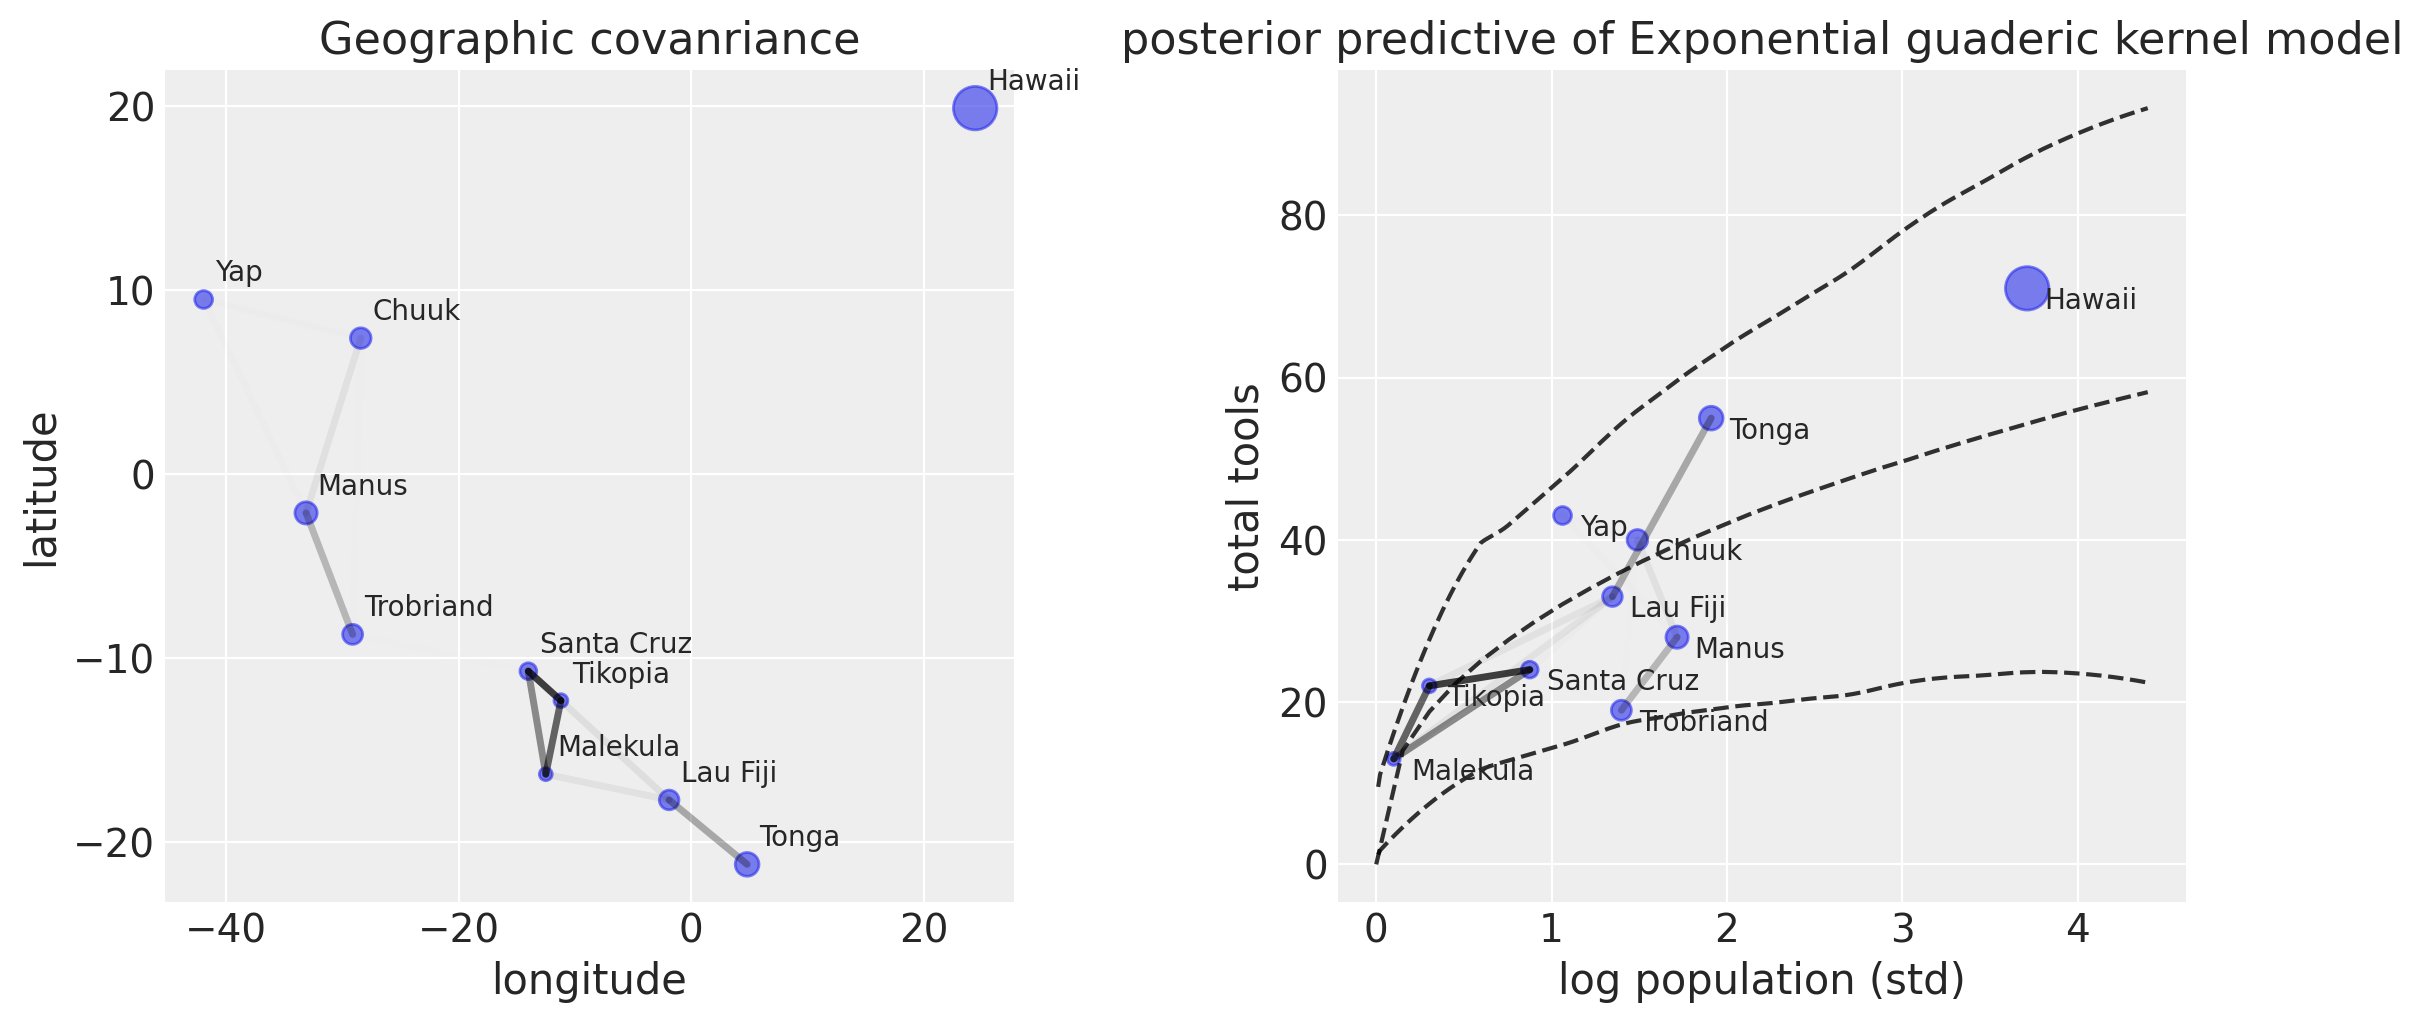

In [ ]:
# scale point size to logpop
logpop = np.copy(dk["logpop"].values)
logpop /= logpop.max()
psize = np.exp(logpop * 5.5)

_, (ax0, ax1) = plt.subplots(1, 2, figsize=(12, 5), constrained_layout=True)

# plot raw data and labels
ax0.scatter(dk["lon2"], dk["lat"], psize, alpha=0.6)
labels = dk["culture"].values
for i, itext in enumerate(labels):
    ax0.text(dk["lon2"][i] + 1, dk["lat"][i] + 1, itext)

# overlay lines shaded by Rho
for i in range(10):
    for j in np.arange(i + 1, 10):
        ax0.plot(
            [dk["lon2"][i], dk["lon2"][j]],
            [dk["lat"][i], dk["lat"][j]],
            "k-",
            alpha=Rho.iloc[i, j] ** 2,
            lw=2.5,
        )

ax0.set_xlabel("longitude")
ax0.set_ylabel("latitude")
ax0.set_title("Geographic covanriance")

# Code 14.45
# compute posterior median relationship, ignoring distance
P_seq = np.linspace(-1.4, 3.0, 30) + 1.4  # our little trick from chp 11
lambda_post = (
    post["a"].values[:, None] * P_seq ** post["b"].values[:, None] / post["g"].values[:, None]
)

# plot raw data and labels
ax1.scatter(P, dk["total_tools"], psize, alpha=0.6)
labels = dk["culture"].values
for i, itext in enumerate(labels):
    ax1.text(P[i] + 0.1, dk["total_tools"][i] - 2.5, itext)

# display posterior predictions
ax1.plot(P_seq, np.median(lambda_post, axis=0), "--", color="k", alpha=0.8)
az.plot_hdi(
    P_seq,
    lambda_post,
    color="k",
    ax=ax1,
    fill_kwargs={"alpha": 0},
    plot_kwargs={"color": "k", "ls": "--", "alpha": 0.8},
)

# overlay correlations
for i in range(10):
    for j in np.arange(i + 1, 10):
        ax1.plot(
            [P[i], P[j]],
            [dk["total_tools"][i], dk["total_tools"][j]],
            "k-",
            alpha=Rho.iloc[i, j] ** 2,
            lw=2.5,
        )

ax1.set_xlabel("log population (std)")
ax1.set_ylabel("total tools");
ax1.set_title("posterior predictive of Exponential guaderic kernel model")

###### Diagnostics of Exponential guaderic kernel model

In [ ]:
az.summary(idata_GEQ, kind="diagnostics")

mcse_mean  mcse_sd  ess_bulk  ess_tail  r_hat
k_rotated_[0]      0.014    0.010    3999.0    5338.0    1.0
k_rotated_[1]      0.013    0.011    3887.0    3176.0    1.0
k_rotated_[2]      0.018    0.013    2722.0    4955.0    1.0
k_rotated_[3]      0.009    0.008    5842.0    4884.0    1.0
k_rotated_[4]      0.013    0.012    4663.0    4830.0    1.0
k_rotated_[5]      0.014    0.010    3463.0    3773.0    1.0
k_rotated_[6]      0.010    0.011    5750.0    4554.0    1.0
k_rotated_[7]      0.020    0.014    2443.0    4388.0    1.0
k_rotated_[8]      0.032    0.023    1241.0    3938.0    1.0
k_rotated_[9]      0.016    0.011    2936.0    4404.0    1.0
a                  0.020    0.014    3479.0    2885.0    1.0
b                  0.003    0.002    2723.0    2158.0    1.0
g                  0.001    0.001    3057.0    2773.0    1.0
etasq              0.007    0.005    2410.0    3925.0    1.0
ls_inv             0.062    0.044     607.0    1637.0    1.0
rhosq              0.130    0.092     607.0    1637.0    1.0
k[0]               0.008    0.006    3544.0    4103.0    1.0
k[1]               0.007    0.005    4290.0    3514.0    1.0
k[2]               0.007    0.005    4417.0    2995.0    1.0
k[3]               0.006    0.005    4720.0    3507.0    1.0
k[4]               0.006    0.005    5110.0    3183.0    1.0
k[5]               0.010    0.007    2290.0    2672.0    1.0
k[6]               0.007    0.006    4260.0    3302.0    1.0
k[7]               0.011    0.008    1936.0    2891.0    1.0
k[8]               0.007    0.005    3410.0    3401.0    1.0
k[9]               0.007    0.006    4042.0    3362.0    1.0

###### liner vs squared distance

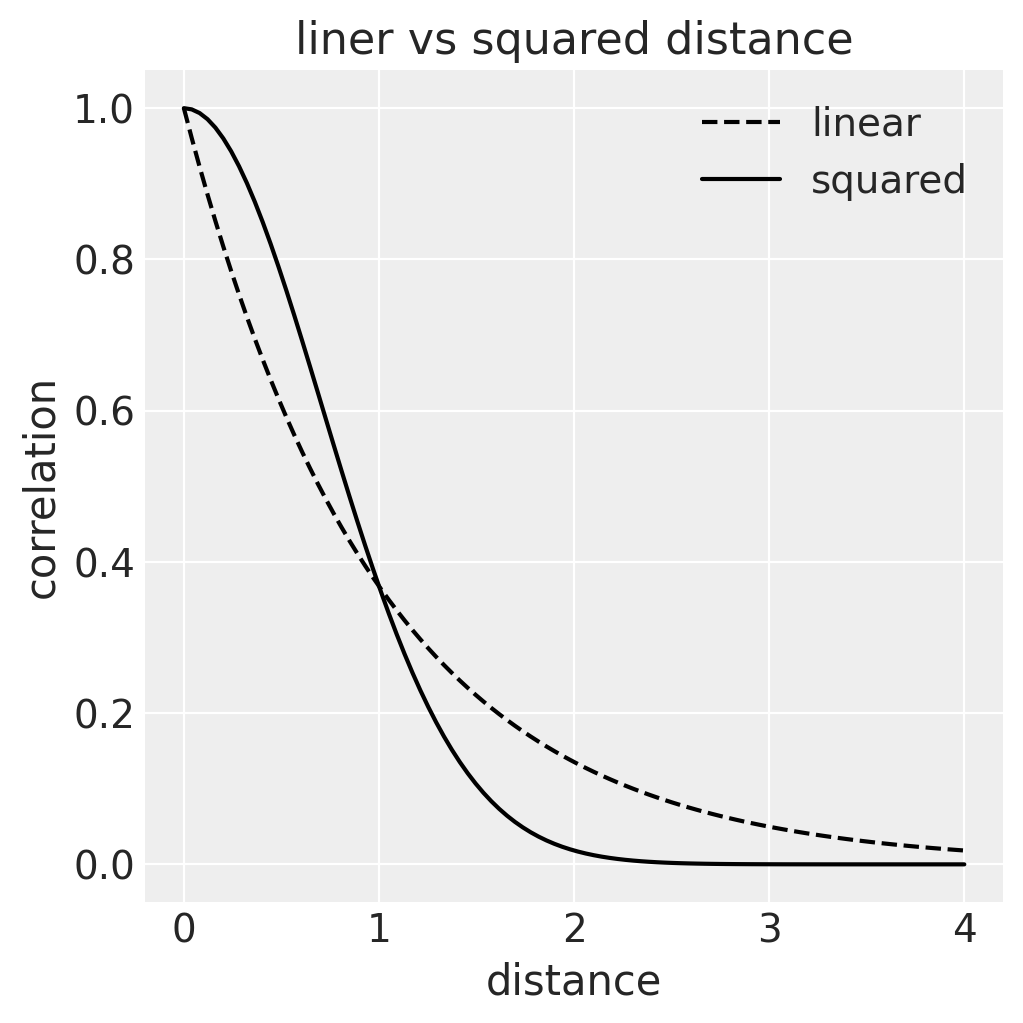

In [ ]:
_, ax = plt.subplots(1, 1, figsize=(5, 5))

xrange = np.linspace(0, 4, 100)
# linear
ax.plot(xrange, np.exp(-1 * xrange), "k--", label="linear")
# squared
ax.plot(xrange, np.exp(-1 * xrange**2), "k", label="squared")

ax.set_xlabel("distance")
ax.set_ylabel("correlation")
ax.set_title("liner vs squared distance")
plt.legend();

##### More kernel model

###### Linear kernel model

In [152]:
with pm.Model() as m_GLin:
    a = pm.Exponential("a", 1.0)
    b = pm.Exponential("b", 1.0)
    g = pm.Exponential("g", 1.0)

    etasq = pm.Exponential("etasq", 2.0)
    ls_inv = pm.HalfNormal("ls_inv", 2.0)
    rhosq = pm.Deterministic("rhosq", 0.5 * ls_inv**2)
    Dmu = Dmat.mean() / 2

    # Implementation with PyMC's GP module:
    cov = etasq * pm.gp.cov.Linear(input_dim=1, c=Dmu)
    gp = pm.gp.Latent(cov_func=cov)
    k = gp.prior("k", X=Dmat)

    lam = (a * P**b / g) * at.exp(k[society])

    T = pm.Poisson("total_tools", lam, observed=total_tools)

    idata_GLin = pm.sample(2000, tune=2000, target_accept=0.99, random_seed=RANDOM_SEED)
    trace_GLin = idata_GLin.posterior

 Posterior predictive of Linear kernel model

In [153]:
# compute posterior median covariance
x_seq = np.linspace(0, 10, 100)
post_GLin = idata_GLin.posterior.stack(sample=("chain", "draw")) #posterior of m_Glin
pmcov_mu_GLin = post_GLin["etasq"].median().values * np.exp(-post_GLin["rhosq"].median().values * (x_seq**2))

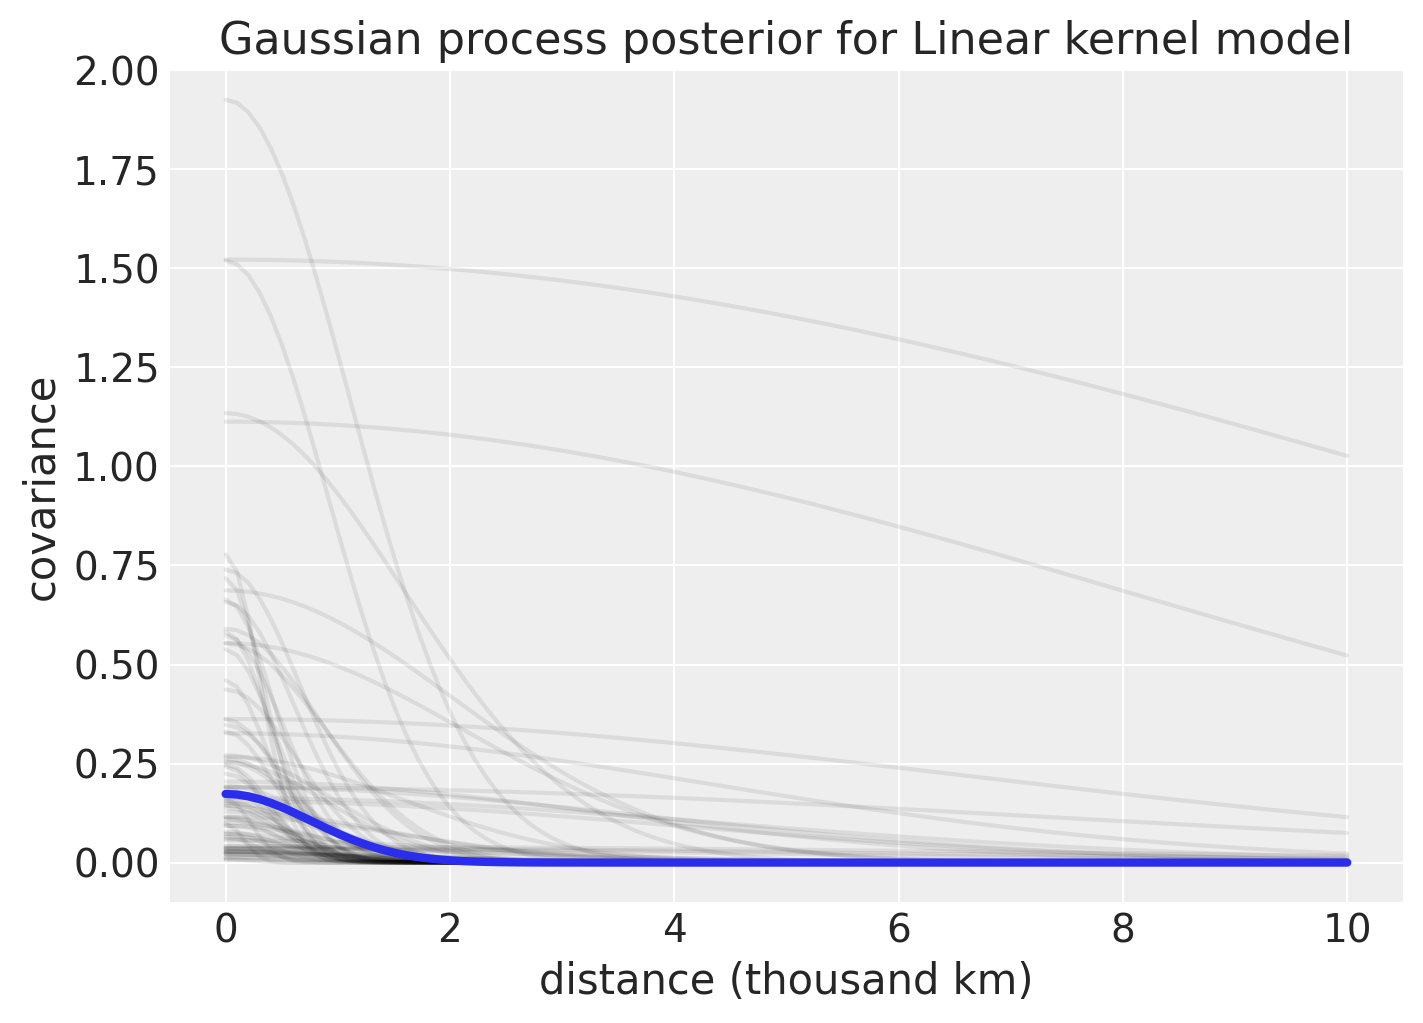

In [165]:
_, ax = plt.subplots(1, 1, figsize=(7, 5))

# plot functions sampled from posterior
ax.plot(
    x_seq,
    (
        post_GLin["etasq"][::50].values[:, None]
        * np.exp(-post_GLin["rhosq"][::50].values[:, None] * (x_seq**2))
    ).T,
    "k",
    alpha=0.08,
)

# plot median covariance function
ax.plot(x_seq, pmcov_mu_GLin, lw=3)

ax.set(
    title="Gaussian process posterior for Linear kernel model",
    ylim=(-0.1, 2),
    xlabel="distance (thousand km)",
    ylabel="covariance",
);

In [154]:
# compute posterior median covariance among societies
K_GLin = post_GLin["etasq"].median().values * np.exp(-post_GLin["rhosq"].median().values * Dmatsq) + np.diag(
    [0.01] * Nsociety
)
# convert to correlation matrix
sigma_post_GLin = np.sqrt(np.diag(K_GLin))
Rho_GLin = (sigma_post_GLin**-1) * K_GLin * (sigma_post_GLin**-1)

# add row/col names for convenience
Rho_GLin = pd.DataFrame(
    Rho_GLin,
    index=["Ml", "Ti", "SC", "Ya", "Fi", "Tr", "Ch", "Mn", "To", "Ha"],
    columns=["Ml", "Ti", "SC", "Ya", "Fi", "Tr", "Ch", "Mn", "To", "Ha"],
)

Rho.round(2)

Ml    Ti    SC    Ya    Fi    Tr    Ch    Mn    To   Ha
Ml  1.00  0.76  0.65  0.00  0.23  0.02  0.00  0.00  0.04  0.0
Ti  0.76  1.00  0.86  0.00  0.23  0.02  0.00  0.00  0.03  0.0
SC  0.65  0.86  1.00  0.00  0.10  0.06  0.00  0.01  0.01  0.0
Ya  0.00  0.00  0.00  1.00  0.00  0.00  0.10  0.08  0.00  0.0
Fi  0.23  0.23  0.10  0.00  1.00  0.00  0.00  0.00  0.55  0.0
Tr  0.02  0.02  0.06  0.00  0.00  1.00  0.05  0.48  0.00  0.0
Ch  0.00  0.00  0.00  0.10  0.00  0.05  1.00  0.24  0.00  0.0
Mn  0.00  0.00  0.01  0.08  0.00  0.48  0.24  1.00  0.00  0.0
To  0.04  0.03  0.01  0.00  0.55  0.00  0.00  0.00  1.00  0.0
Ha  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  1.0

Text(0.5, 1.0, 'posterior predictive of Linear kernel model')

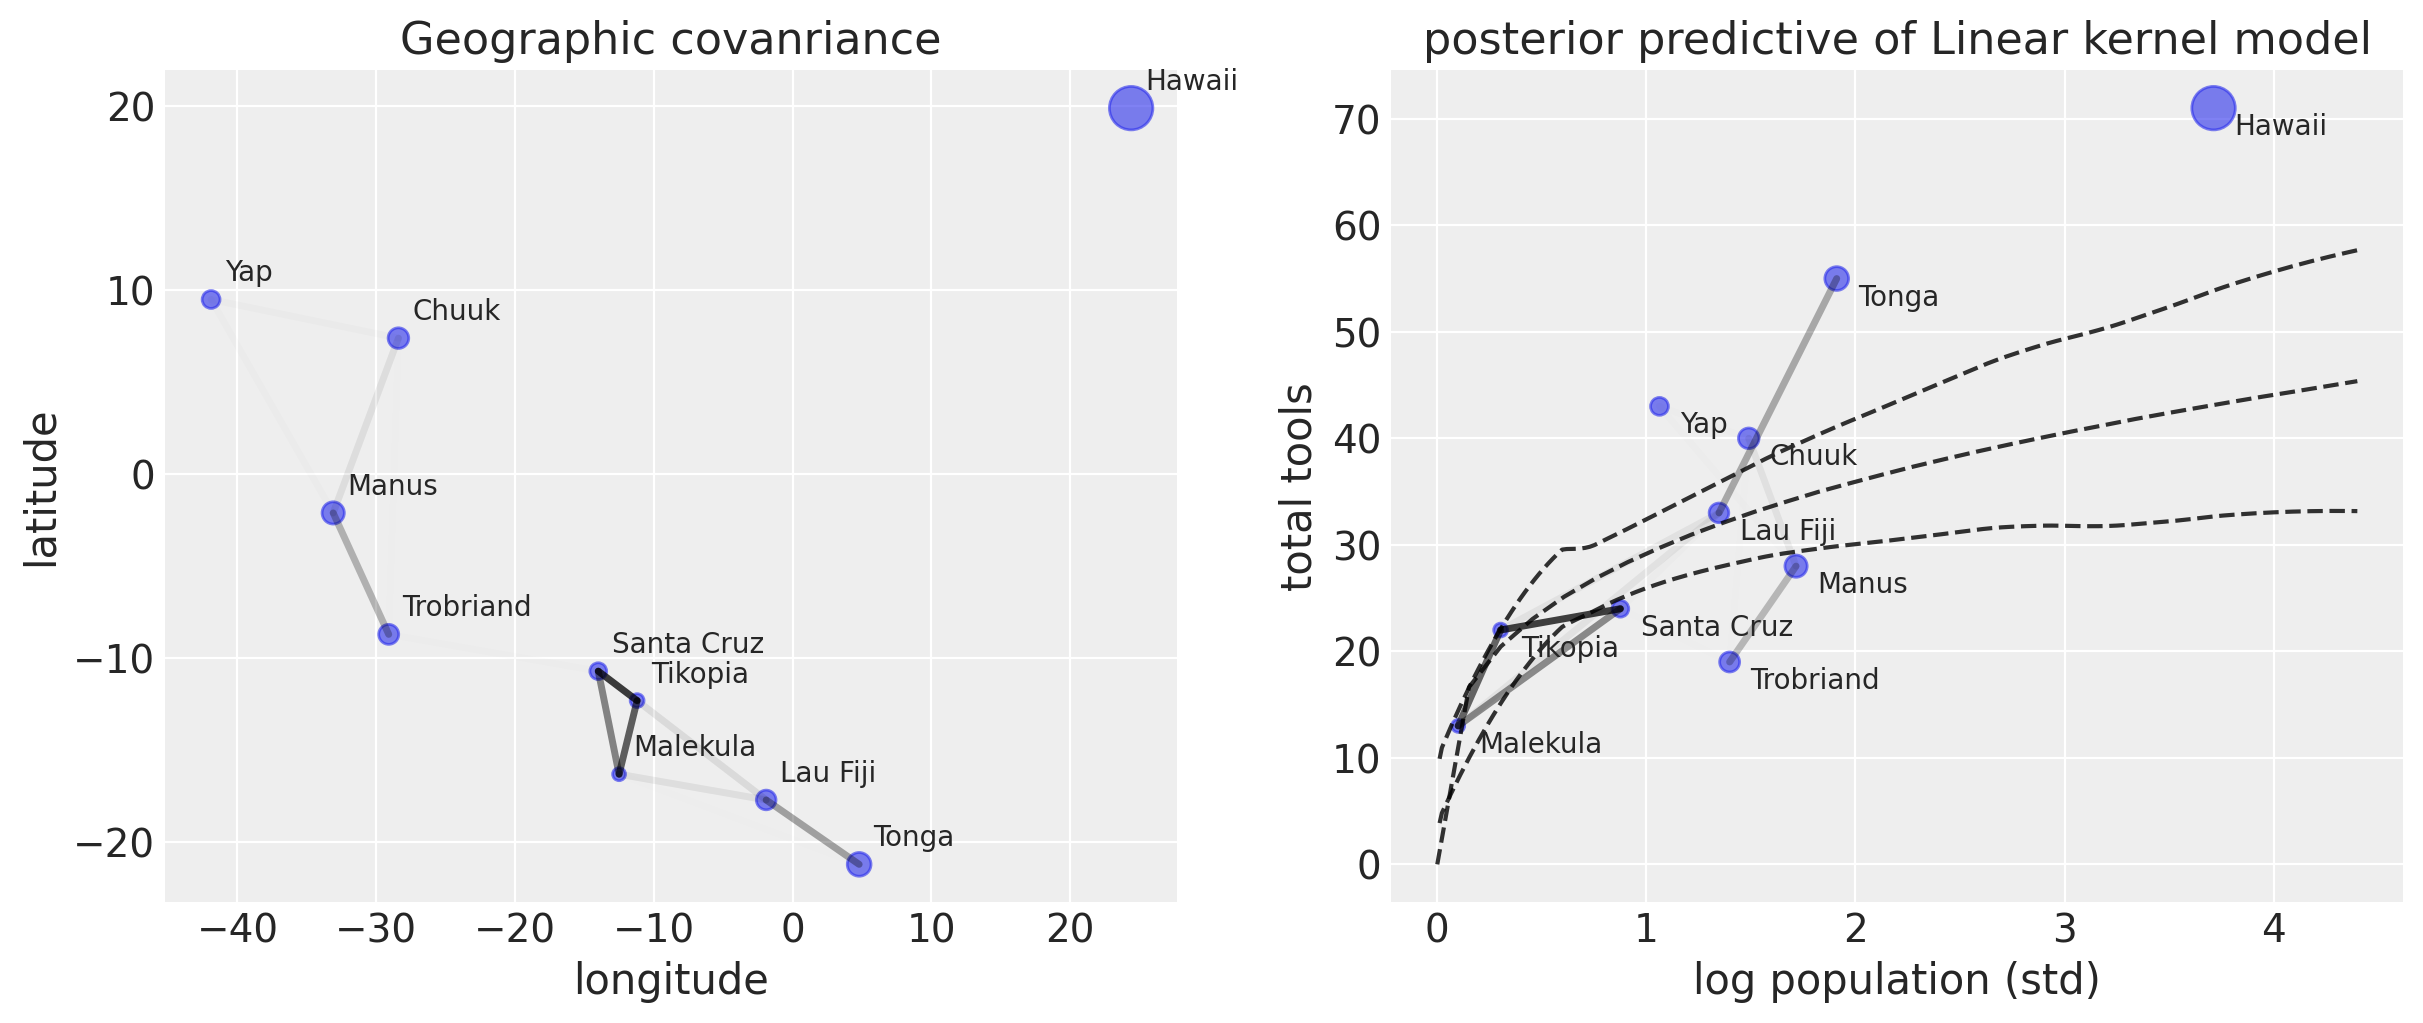

In [155]:
# scale point size to logpop
logpop = np.copy(dk["logpop"].values)
logpop /= logpop.max()
psize = np.exp(logpop * 5.5)

_, (ax0, ax1) = plt.subplots(1, 2, figsize=(12, 5), constrained_layout=True)

# plot raw data and labels
ax0.scatter(dk["lon2"], dk["lat"], psize, alpha=0.6)
labels = dk["culture"].values
for i, itext in enumerate(labels):
    ax0.text(dk["lon2"][i] + 1, dk["lat"][i] + 1, itext)

# overlay lines shaded by Rho_GLin
for i in range(10):
    for j in np.arange(i + 1, 10):
        ax0.plot(
            [dk["lon2"][i], dk["lon2"][j]],
            [dk["lat"][i], dk["lat"][j]],
            "k-",
            alpha=Rho_GLin.iloc[i, j] ** 2,
            lw=2.5,
        )

ax0.set_xlabel("longitude")
ax0.set_ylabel("latitude")
ax0.set_title("Geographic covanriance")
# Code 14.45
# compute posterior median relationship, ignoring distance
P_seq = np.linspace(-1.4, 3.0, 30) + 1.4  # our little trick from chp 11
lambda_post_GLin = (
    post_GLin["a"].values[:, None] * P_seq ** post_GLin["b"].values[:, None] / post_GLin["g"].values[:, None]
)

# plot raw data and labels
ax1.scatter(P, dk["total_tools"], psize, alpha=0.6)
labels = dk["culture"].values
for i, itext in enumerate(labels):
    ax1.text(P[i] + 0.1, dk["total_tools"][i] - 2.5, itext)

# display posterior predictions
ax1.plot(P_seq, np.median(lambda_post_GLin, axis=0), "--", color="k", alpha=0.8)
az.plot_hdi(
    P_seq,
    lambda_post_GLin,
    color="k",
    ax=ax1,
    fill_kwargs={"alpha": 0},
    plot_kwargs={"color": "k", "ls": "--", "alpha": 0.8},
)

# overlay correlations
for i in range(10):
    for j in np.arange(i + 1, 10):
        ax1.plot(
            [P[i], P[j]],
            [dk["total_tools"][i], dk["total_tools"][j]],
            "k-",
            alpha=Rho.iloc[i, j] ** 2,
            lw=2.5,
        )

ax1.set_xlabel("log population (std)")
ax1.set_ylabel("total tools");
ax1.set_title("posterior predictive of Linear kernel model")

Diagnostics of Linear kernel model

In [ ]:
az.summary(idata_GLin, kind="diagnostics")

mcse_mean  mcse_sd  ess_bulk  ess_tail  r_hat
k_rotated_[0]      0.012    0.009     987.0     751.0    1.0
k_rotated_[1]      0.015    0.016    4495.0    3102.0    1.0
k_rotated_[2]      0.017    0.016    3586.0    2831.0    1.0
k_rotated_[3]      0.017    0.015    3736.0    2909.0    1.0
k_rotated_[4]      0.015    0.016    4322.0    2995.0    1.0
k_rotated_[5]      0.017    0.016    3625.0    3006.0    1.0
k_rotated_[6]      0.016    0.016    4288.0    2899.0    1.0
k_rotated_[7]      0.017    0.016    3693.0    2801.0    1.0
k_rotated_[8]      0.015    0.015    4133.0    3094.0    1.0
k_rotated_[9]      0.018    0.015    3171.0    2763.0    1.0
a                  0.034    0.024    1078.0     670.0    1.0
b                  0.002    0.001    3304.0    2064.0    1.0
g                  0.001    0.001    1088.0     665.0    1.0
etasq              0.008    0.005    1022.0    1021.0    1.0
ls_inv             0.018    0.013    2760.0    1357.0    1.0
rhosq              0.037    0.031    2760.0    1357.0    1.0
k[0]               0.001    0.001    3322.0    3028.0    1.0
k[1]               0.001    0.001    3319.0    3110.0    1.0
k[2]               0.001    0.000    3312.0    3073.0    1.0
k[3]               0.002    0.002    3316.0    3111.0    1.0
k[4]               0.000    0.000    3335.0    3124.0    1.0
k[5]               0.000    0.000    3308.0    3082.0    1.0
k[6]               0.001    0.001    3313.0    3074.0    1.0
k[7]               0.001    0.001    3315.0    3135.0    1.0
k[8]               0.000    0.000    3324.0    3074.0    1.0
k[9]               0.003    0.002    3316.0    3085.0    1.0

######  Exponential kernel model

In [ ]:
with pm.Model() as m_GExp:
    a = pm.Exponential("a", 1.0)
    b = pm.Exponential("b", 1.0)
    g = pm.Exponential("g", 1.0)

    etasq = pm.Exponential("etasq", 2.0)
    ls_inv = pm.HalfNormal("ls_inv", 2.0)
    rhosq = pm.Deterministic("rhosq", 0.5 * ls_inv**2)

    # Implementation with PyMC's GP module:
    cov = etasq * pm.gp.cov.Exponential(input_dim=1, ls_inv=ls_inv)
    gp = pm.gp.Latent(cov_func=cov)
    k = gp.prior("k", X=Dmat)

    lam = (a * P**b / g) * at.exp(k[society])

    T = pm.Poisson("total_tools", lam, observed=total_tools)

    idata_GExp = pm.sample(2000, tune=2000, target_accept=0.99, random_seed=RANDOM_SEED)
    trace_GExp = idata_GExp.posterior

 Posterior predictive of Exponential kernel model

In [158]:
# compute posterior median covariance
x_seq = np.linspace(0, 10, 100)
post_GExp = idata_GExp.posterior.stack(sample=("chain", "draw"))#posterior of m_GExp
pmcov_mu_GExp = post_GExp["etasq"].median().values * np.exp(-post_GExp["rhosq"].median().values * (x_seq**2))


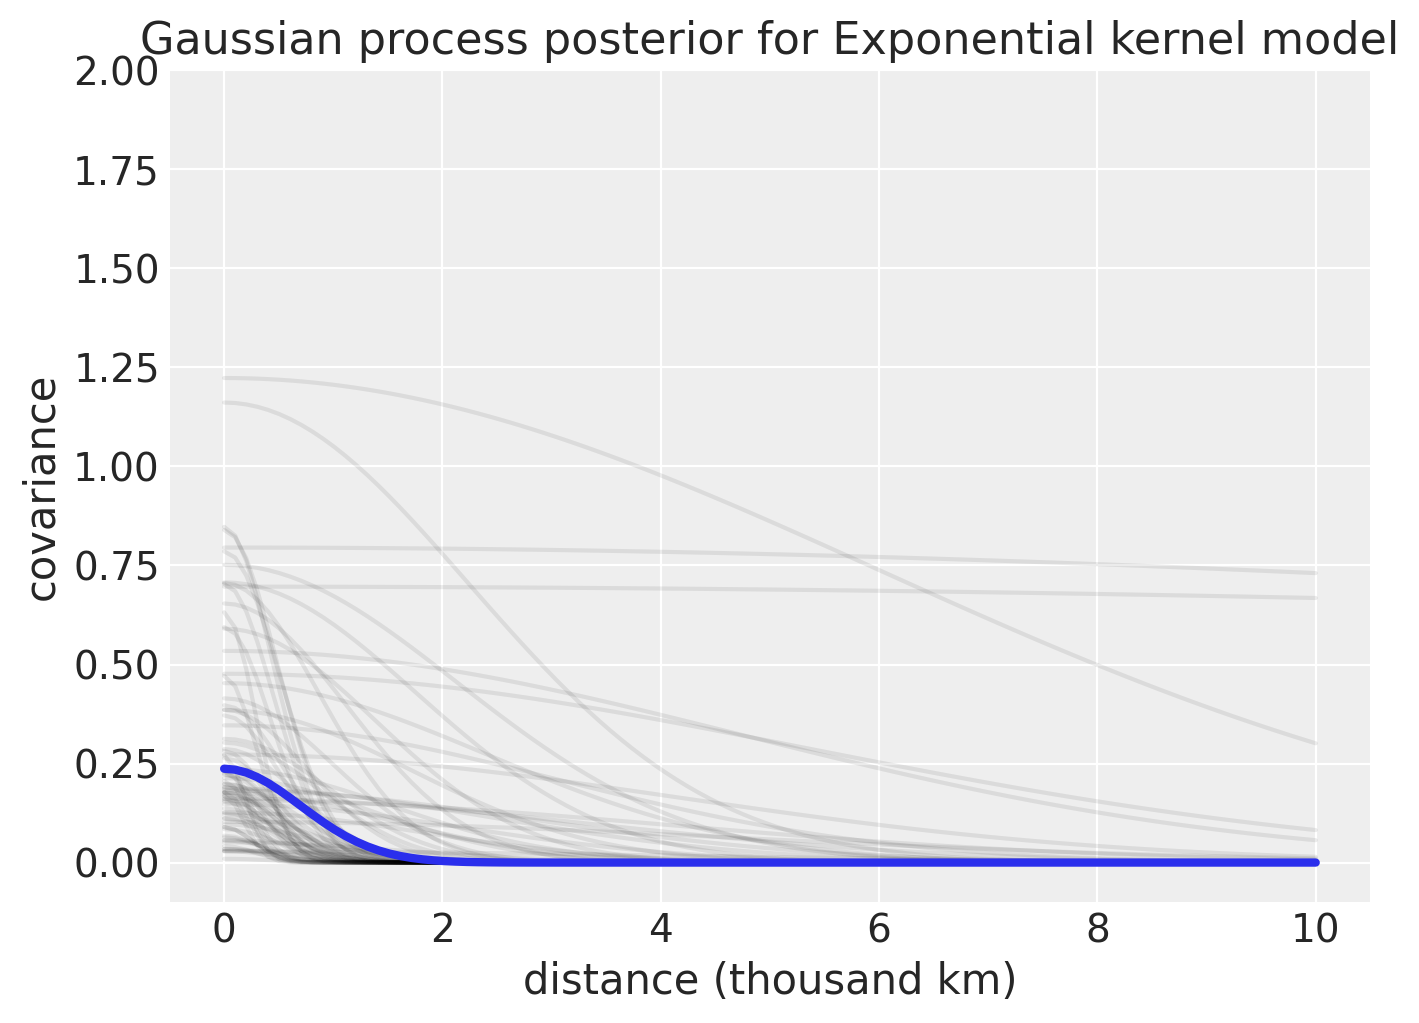

In [171]:
_, ax = plt.subplots(1, 1, figsize=(7, 5))

# plot functions sampled from posterior
ax.plot(
    x_seq,
    (
        post_GExp["etasq"][::50].values[:, None]
        * np.exp(-post_GExp["rhosq"][::50].values[:, None] * (x_seq**2))
    ).T,
    "k",
    alpha=0.08,
)

# plot median covariance function
ax.plot(x_seq, pmcov_mu_GExp, lw=3)

ax.set(
    title="Gaussian process posterior for Exponential kernel model",
    ylim=(-0.1, 2),
    xlabel="distance (thousand km)",
    ylabel="covariance",
);

In [159]:
# compute posterior median covariance among societies
K_GExp = post_GExp["etasq"].median().values * np.exp(-post_GExp["rhosq"].median().values * Dmatsq) + np.diag(
    [0.01] * Nsociety
)
# convert to correlation matrix
sigma_post_GExp = np.sqrt(np.diag(K_GExp))
Rho_GExp = (sigma_post_GExp**-1) * K_GExp * (sigma_post_GExp**-1)

# add row/col names for convenience
Rho_GExp = pd.DataFrame(
    Rho_GExp,
    index=["Ml", "Ti", "SC", "Ya", "Fi", "Tr", "Ch", "Mn", "To", "Ha"],
    columns=["Ml", "Ti", "SC", "Ya", "Fi", "Tr", "Ch", "Mn", "To", "Ha"],
)

Rho.round(2)

Ml    Ti    SC    Ya    Fi    Tr    Ch    Mn    To   Ha
Ml  1.00  0.76  0.65  0.00  0.23  0.02  0.00  0.00  0.04  0.0
Ti  0.76  1.00  0.86  0.00  0.23  0.02  0.00  0.00  0.03  0.0
SC  0.65  0.86  1.00  0.00  0.10  0.06  0.00  0.01  0.01  0.0
Ya  0.00  0.00  0.00  1.00  0.00  0.00  0.10  0.08  0.00  0.0
Fi  0.23  0.23  0.10  0.00  1.00  0.00  0.00  0.00  0.55  0.0
Tr  0.02  0.02  0.06  0.00  0.00  1.00  0.05  0.48  0.00  0.0
Ch  0.00  0.00  0.00  0.10  0.00  0.05  1.00  0.24  0.00  0.0
Mn  0.00  0.00  0.01  0.08  0.00  0.48  0.24  1.00  0.00  0.0
To  0.04  0.03  0.01  0.00  0.55  0.00  0.00  0.00  1.00  0.0
Ha  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  1.0

Text(0.5, 1.0, 'posterior predictive of Exponential kernel model')

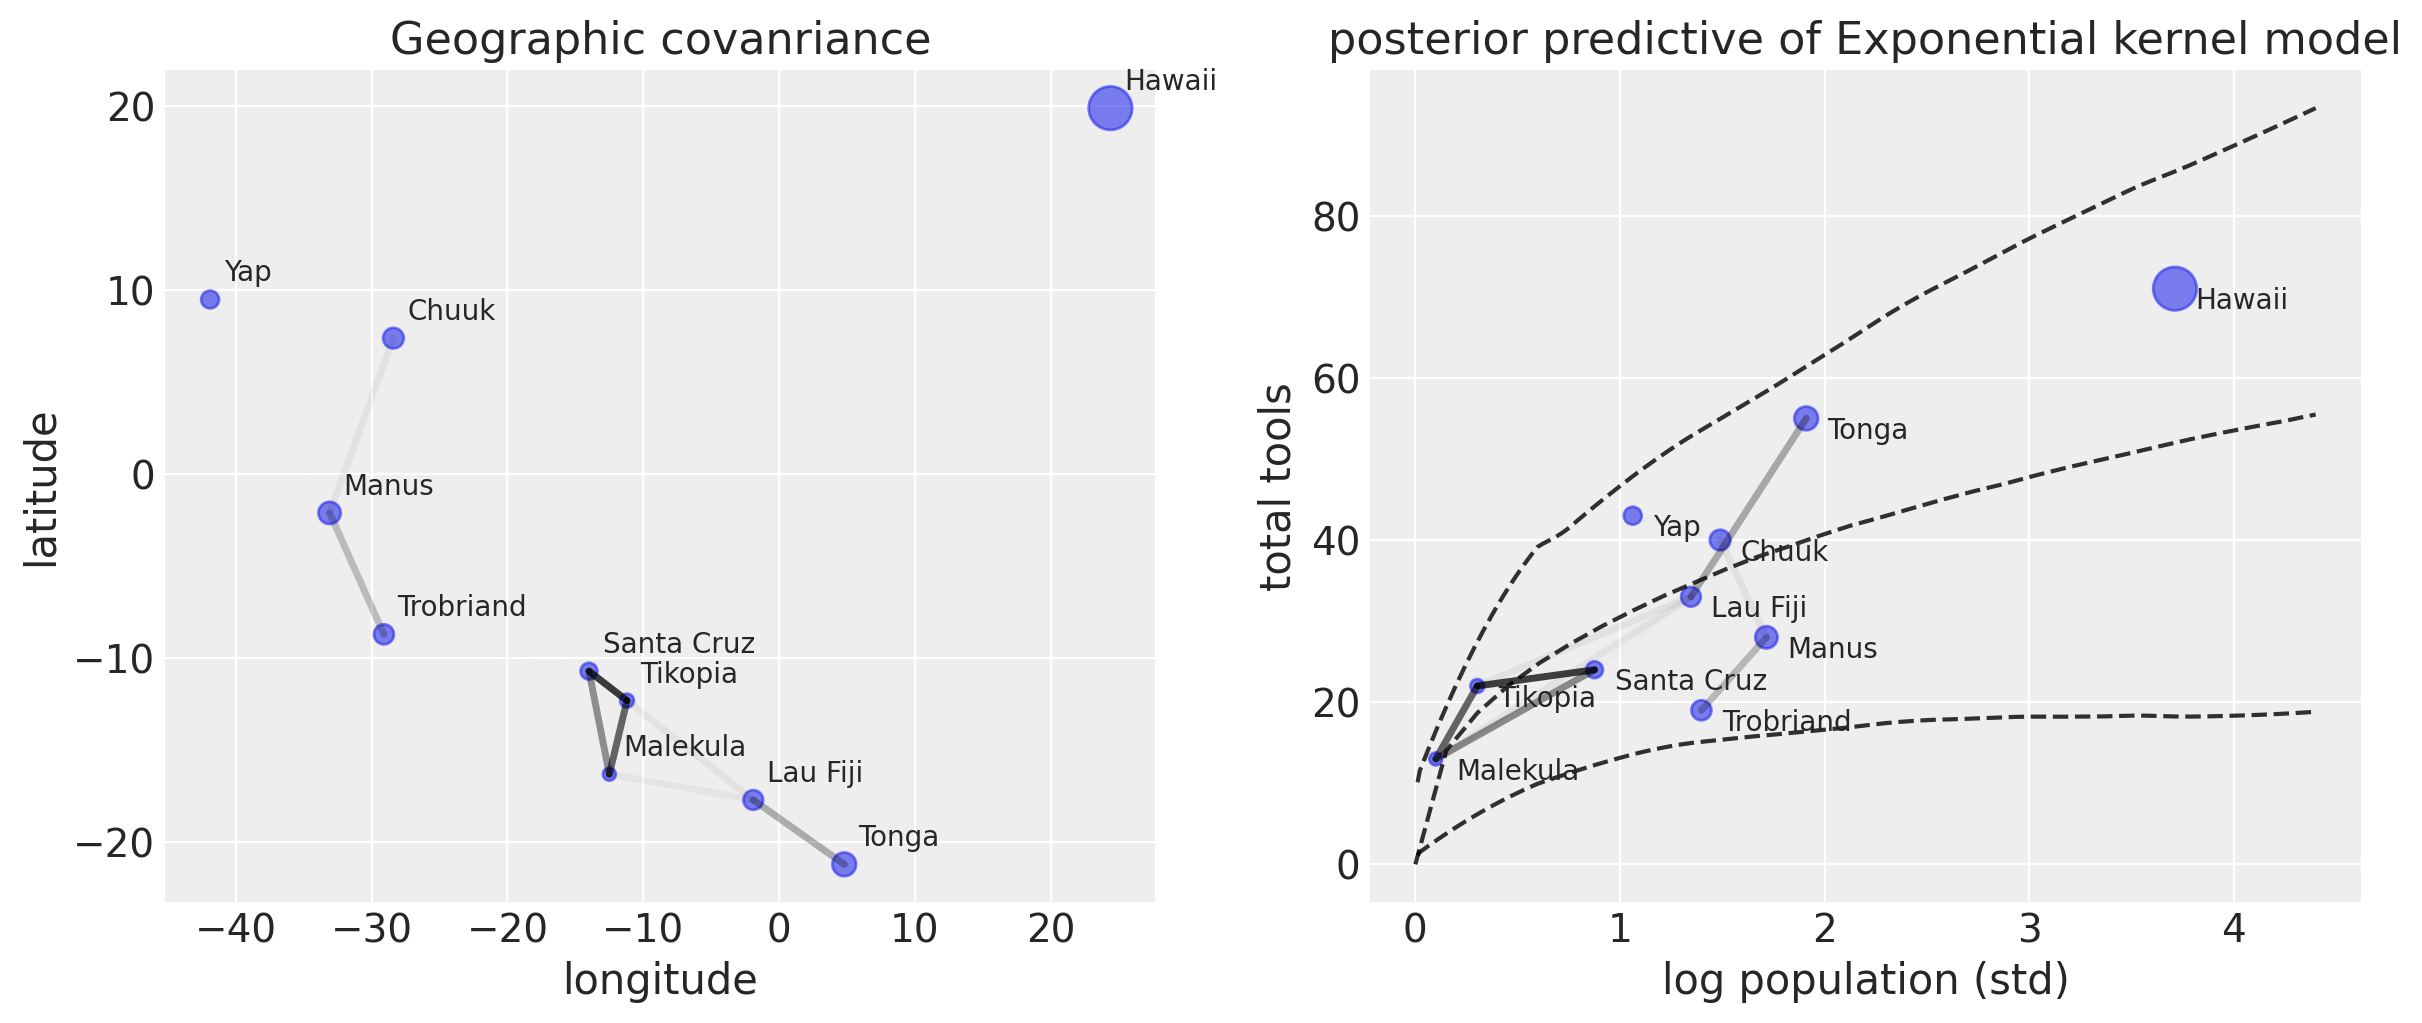

In [160]:
# Code 14.44
# scale point size to logpop
logpop = np.copy(dk["logpop"].values)
logpop /= logpop.max()
psize = np.exp(logpop * 5.5)

_, (ax0, ax1) = plt.subplots(1, 2, figsize=(12, 5), constrained_layout=True)

# plot raw data and labels
ax0.scatter(dk["lon2"], dk["lat"], psize, alpha=0.6)
labels = dk["culture"].values
for i, itext in enumerate(labels):
    ax0.text(dk["lon2"][i] + 1, dk["lat"][i] + 1, itext)

# overlay lines shaded by Rho_GExp
for i in range(10):
    for j in np.arange(i + 1, 10):
        ax0.plot(
            [dk["lon2"][i], dk["lon2"][j]],
            [dk["lat"][i], dk["lat"][j]],
            "k-",
            alpha=Rho_GExp.iloc[i, j] ** 2,
            lw=2.5,
        )

ax0.set_xlabel("longitude")
ax0.set_ylabel("latitude")
ax0.set_title("Geographic covanriance")
# Code 14.45
# compute posterior median relationship, ignoring distance
P_seq = np.linspace(-1.4, 3.0, 30) + 1.4  # our little trick from chp 11
lambda_post_GExp = (
    post_GExp["a"].values[:, None] * P_seq ** post_GExp["b"].values[:, None] / post_GExp["g"].values[:, None]
)

# plot raw data and labels
ax1.scatter(P, dk["total_tools"], psize, alpha=0.6)
labels = dk["culture"].values
for i, itext in enumerate(labels):
    ax1.text(P[i] + 0.1, dk["total_tools"][i] - 2.5, itext)

# display posterior predictions
ax1.plot(P_seq, np.median(lambda_post_GExp, axis=0), "--", color="k", alpha=0.8)
az.plot_hdi(
    P_seq,
    lambda_post_GExp,
    color="k",
    ax=ax1,
    fill_kwargs={"alpha": 0},
    plot_kwargs={"color": "k", "ls": "--", "alpha": 0.8},
)

# overlay correlations
for i in range(10):
    for j in np.arange(i + 1, 10):
        ax1.plot(
            [P[i], P[j]],
            [dk["total_tools"][i], dk["total_tools"][j]],
            "k-",
            alpha=Rho.iloc[i, j] ** 2,
            lw=2.5,
        )

ax1.set_xlabel("log population (std)")
ax1.set_ylabel("total tools");
ax1.set_title("posterior predictive of Exponential kernel model")

Diagnostics of Exponential kernel model

In [ ]:
az.summary(idata_GExp, kind="diagnostics")

mcse_mean  mcse_sd  ess_bulk  ess_tail  r_hat
k_rotated_[0]      0.018    0.014    2472.0    2770.0    1.0
k_rotated_[1]      0.014    0.013    2844.0    2252.0    1.0
k_rotated_[2]      0.016    0.012    2819.0    2920.0    1.0
k_rotated_[3]      0.013    0.009    2284.0    2756.0    1.0
k_rotated_[4]      0.012    0.011    2583.0    1986.0    1.0
k_rotated_[5]      0.010    0.008    3268.0    2590.0    1.0
k_rotated_[6]      0.012    0.010    2511.0    2106.0    1.0
k_rotated_[7]      0.011    0.010    3959.0    2868.0    1.0
k_rotated_[8]      0.015    0.010    3058.0    1781.0    1.0
k_rotated_[9]      0.015    0.010    1956.0    2910.0    1.0
a                  0.026    0.019    1950.0    1459.0    1.0
b                  0.004    0.003    1351.0     814.0    1.0
g                  0.002    0.001    1741.0    1485.0    1.0
etasq              0.007    0.005    1717.0    2398.0    1.0
ls_inv             0.028    0.020    1601.0    1929.0    1.0
rhosq              0.056    0.040    1601.0    1929.0    1.0
k[0]               0.011    0.008    2124.0    2429.0    1.0
k[1]               0.010    0.007    2180.0    2428.0    1.0
k[2]               0.010    0.007    2293.0    2264.0    1.0
k[3]               0.010    0.007    2051.0    2161.0    1.0
k[4]               0.010    0.007    2077.0    2250.0    1.0
k[5]               0.011    0.008    1923.0    2136.0    1.0
k[6]               0.010    0.007    1993.0    2221.0    1.0
k[7]               0.010    0.007    2071.0    2092.0    1.0
k[8]               0.011    0.008    1911.0    2377.0    1.0
k[9]               0.012    0.008    1709.0    2135.0    1.0

In [ ]:
az.compare({"m_Pois": idata_Pois, "m_GEQ": idata_GEQ,"idata_GExp": idata_GExp, "idata_GLin": idata_GLin})

rank       waic    p_waic     d_waic        weight         se  \
idata_GExp     0  76.314460  7.307584   0.000000  8.810918e-01   6.389583   
idata_GLin     1  82.388013  4.870556   6.073553  1.189082e-01  12.250044   
m_GEQ          2  84.640274  9.893647   8.325814  1.075864e-15  10.742263   
m_Pois         3  95.227185  9.555947  18.912724  0.000000e+00  12.257897   

                 dse  warning waic_scale  
idata_GExp  0.000000     True   deviance  
idata_GLin  6.607758     True   deviance  
m_GEQ       4.637348     True   deviance  
m_Pois      8.592892     True   deviance

### model compare

In [ ]:
az.compare({"m_Pois": idata_Pois, "m_GEQ": idata_GEQ})

rank       waic    p_waic     d_waic    weight         se       dse  \
m_GEQ      0  84.640274  9.893647   0.000000  0.812327  10.742263  0.000000   
m_Pois     1  95.227185  9.555947  10.586911  0.187673  12.257897  9.358017   

        warning waic_scale  
m_GEQ      True   deviance  
m_Pois     True   deviance

# Watermark

In [ ]:
%%capture
!pip install watermark

In [ ]:
%load_ext watermark
%watermark -v -iv -w

Python implementation: CPython
Python version       : 3.8.16
IPython version      : 7.9.0

matplotlib: 3.2.2
arviz     : 0.12.1
pandas    : 1.3.5
scipy     : 1.7.3
aesara    : 2.7.9
numpy     : 1.21.6
pymc      : 4.1.4

Watermark: 2.3.1

